# Analysis of Basic RAG Pipeline with GPT-3.5-Turbo

**Database**: Max Tokens 120, Sentence Chunking, Overlap 20

**Instructions**: "You are a glycobiology assistant for GlyGen that helps scientists navigate and utilize a bioinformatics knowledgebase."

**Prompt Template**: 

"Context information from 'Essentials of Glycobiology' (4th edition) is below.\n" \
"---------------------\n" \
"{context_str}\n" \
"---------------------\n" \
"Given the information from the selected text and not prior knowledge, " \
"answer the query.\n" \
"Query: {query_str}\n" \
"Answer: "

**Retrieval**: Top-K = 5, Response Mode = "tree-summarize"

**LLM, Embedding Model**: GPT-3.5-Turbo for both

**Dummy Comparison Constraints**: RAG with GPT-4o Glycobiology Definition

### About the RAGAS Metrics:

**Faithfulness** -> measures the factual consistency of the generated answer against the given context. It is calculated from answer and retrieved context. The answer is scaled to (0,1) range. Higher the better.

**Answer Relevance** -> focuses on assessing how pertinent the generated answer is to the given prompt. A lower score is assigned to answers that are incomplete or contain redundant information and higher scores indicate better relevancy. This metric is computed using the question, the context and the answer.

**Answer Semantic Similarity** -> semantic resemblance between the generated answer and the ground truth. This evaluation is based on the ground truth and the answer, with values falling within the range of 0 to 1. A higher score signifies a better alignment between the generated answer and the ground truth.

**Context Relevance** *RECENTLY DEPRECATED* -> gauges the ratio of question-relevant sentences in the contexts to estimate the amount of essential information in the retrieved contexts. To compute this, we initially estimate the value of |*S*| by identifying sentences within the retrieved context that are relevant for answering the given question. The values fall within the range of (0, 1), with higher values indicating better relevancy.

**Context Precision** -> evaluates whether all of the ground-truth relevant items present in the contexts are ranked higher or not. Ideally all the relevant chunks must appear at the top ranks. This metric is computed using the question, ground_truth and the contexts, with values ranging between 0 and 1, where higher scores indicate better precision.

**Context Recall** -> extent to which the retrieved context aligns with the annotated answer, treated as the ground truth. It is computed based on the ground truth and the retrieved context, and the values range between 0 and 1, with higher values indicating better performance.

In [115]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize, PunktSentenceTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.stats import pearsonr, spearmanr

### Helper Functions

In [116]:
# helper function for preprocessing contexts
def extract_context_list(sample):
    """converts the contexts column into a list of strings"""
    sample = sample.replace('[', '')
    sample = sample.replace(']', '')
    sample = sample.split('\n')
    for i, t in enumerate(sample):
        sample[i] = t[1:-1]
        if sample[i][0] == "'":
            sample[i] = sample[i][1:]

    return sample

# helper function to compute sentence recall
def sent_recall(target: str, contexts: list) -> float:
    """Computes sentence recall between target and contexts"""
    sentence_tokenizer = PunktSentenceTokenizer()
    target_sentences = sentence_tokenizer.tokenize(target)
    context_sentences = []
    for context in contexts:
        context_sentences.extend(sentence_tokenizer.tokenize(context))
    hits = [True for sentence in target_sentences if sentence in context_sentences]
    return len(hits) / len(context_sentences)

# helper function to compute sentence precision
def sent_precision(target: str, contexts: list) -> float:
    """Computes sentence precision between target and contexts"""
    sentence_tokenizer = PunktSentenceTokenizer()
    target_sentences = sentence_tokenizer.tokenize(target)
    context_sentences = []
    for context in contexts:
        context_sentences.extend(sentence_tokenizer.tokenize(context))
    hits = [True for sentence in target_sentences if sentence in context_sentences]
    return len(hits) / len(target_sentences)

# helper function to compute n-gram recall
def ngram_recall(target: str, contexts: list, n: int) -> float:
    """Computes unique n-gram recall between target and contexts"""
    target = word_tokenize(target)
    contexts = [word_tokenize(context) for context in contexts]
    target_ngrams = set([''.join(target[i:i+n]) for i in range(len(target)-n+1)])
    context_ngrams = []
    for context in contexts:
        context_ngrams.extend([''.join(context[i:i+n]) for i in range(len(context)-n+1)])
    hits = [True for ngram in target_ngrams if ngram in set(context_ngrams)]
    raw = len(hits) / len(set(context_ngrams))
    return raw

# helper function to compute n-gram precision
def ngram_precision(target: str, contexts: list, n: int) -> float:
    """Computes unique n-gram precision between target and contexts"""
    target = word_tokenize(target)
    contexts = [word_tokenize(context) for context in contexts]
    target_ngrams = set([''.join(target[i:i+n]) for i in range(len(target)-n+1)])
    context_ngrams = []
    for context in contexts:
        context_ngrams.extend([''.join(context[i:i+n]) for i in range(len(context)-n+1)])
    hits = [True for ngram in target_ngrams if ngram in set(context_ngrams)]
    raw = len(hits) / len(target_ngrams)
    return raw

# TF-IDF helper fxs
# Create the vectorizer
vectorizer = TfidfVectorizer(analyzer='word', max_df=0.5, stop_words='english')

# helper fx
def vectorize_answers(answers, target, vectorizer):
    """vectorizes the answers against given target"""
    matrix = pd.concat([answers, target], 
                       keys=['answers','targets'],
                       names=['group', 'index'],
                       ignore_index=False
                       )
    print(matrix.shape) # unified vocabularies
    matrix = vectorizer.fit_transform(matrix)
    print(matrix.shape) # show tf-idf embeddings for each word in answer/target
    features = vectorizer.get_feature_names_out()
    print(features)
    return matrix, features # return tf-idf embeddings and corresponding words

def ans_target_cosine_similarity(matrix, n) -> np.array:
    """
    Given tf-idf vectors of answer/target in a flattened array, where n reflects the number of samples,
    re-aligns the questions and computes the cosine similarity of their tf-idf embeddings.
    """
    pairwise = cosine_similarity(
        X = matrix[:n],
        Y = matrix[n:]
    )
    print(pairwise.shape)
    x_y = np.diagonal(pairwise)
    return x_y

In [117]:
def custom_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a dataframe of RAGAS results, computes the following metrics:

    - Sentence Overlap (Precision/Recall)
        + Sentence precision/recall scores between ground truth and retrieved context
        + Primarily useful on the continuation questions to establish retrieval quality
        + Establishes if the LLM could "cheat" by repeating the context (in this case its a good thing)

    - N-gram Context Precision/Recall
        + Unique n-gram precision and recall scores between answer and context (proxy for information usage)
        + Note that recall scores need to be normalized to context length

    - Query Context Similarity
        + Cosine similarity between question and context tf-idf embeddings
        + Indicates the relevance of the context to the question
        + Subdivided by individual context chunk for more granular analysis

    - TF-IDF Cosine Similarity
        + More interpretable comparison for RAGAS answer semantic similarity based on tf-idf embeddings.
        + Indicates the literal similarity between LLM-output and human responses based on key words.
    """
    
    # preprocess
    df['contexts'] = df['contexts'].apply(extract_context_list)

    # Sentence Precision/Recall (Context -> Ground Truth)
    df['context_GT_sent_precision'] = df.apply(lambda x: sent_precision(x['ground_truth'], x['contexts']), axis=1)
    df['context_GT_sent_recall'] = df.apply(lambda x: sent_recall(x['ground_truth'], x['contexts']), axis=1)

    # N-Gram (Context -> Response) Precision/Recall
    df['4-gram_context_precision'] = df.apply(lambda x: ngram_precision(x['answer'], x['contexts'], 4), axis=1)
    df['4-gram_context_recall'] = df.apply(lambda x: ngram_recall(x['answer'], x['contexts'], 4), axis=1)

    # Query Context Similarity - estimates relevance of context to question
    context_k = {}
    for contexts in df['contexts']:
        for k, context in enumerate(contexts, start=1):
            if k not in context_k:
                context_k[k] = []
            context_k[k].append(context)
    
    for k in context_k:
        print(k)
        matrix, features = vectorize_answers(df['question'], pd.Series(context_k[k]), vectorizer)
        df[f"context_{k}_query_tfidf_cos"] = ans_target_cosine_similarity(matrix, df.shape[0])

    # TF-IDF Cosine Similarity
    matrix, features = vectorize_answers(df['answer'], df['ground_truth'], vectorizer)
    df['tfidf_cosine_similarity'] = ans_target_cosine_similarity(matrix, df.shape[0])
    # discard features for now - may examine key words later
    del features

    # return the dataframe with the computed metrics
    return df


In [118]:

path_tmpl = ("./results/{database_params}/response_evaluation_{top_k}/ragas_curated.csv")

df120k3 = pd.read_csv(path_tmpl.format(database_params="openai-tok120-ovl20", top_k='3'))
df120k5 = pd.read_csv(path_tmpl.format(database_params="openai-tok120-ovl20", top_k='5'))
df120k7 = pd.read_csv(path_tmpl.format(database_params="openai-tok120-ovl20", top_k='7'))
df120dum = pd.read_csv(path_tmpl.format(database_params="openai-tok120-ovl20", top_k='dum'))
df240k3 = pd.read_csv(path_tmpl.format(database_params="openai-tok240-ovl40", top_k='3'))
df240k5 = pd.read_csv(path_tmpl.format(database_params="openai-tok240-ovl40", top_k='5'))
df240k7 = pd.read_csv(path_tmpl.format(database_params="openai-tok240-ovl40", top_k='7'))
df240dum = pd.read_csv(path_tmpl.format(database_params="openai-tok240-ovl40", top_k='dum'))
df480k3 = pd.read_csv(path_tmpl.format(database_params="openai-tok480-ovl80", top_k='3'))
df480k5 = pd.read_csv(path_tmpl.format(database_params="openai-tok480-ovl80", top_k='5'))
df480k7 = pd.read_csv(path_tmpl.format(database_params="openai-tok480-ovl80", top_k='7'))
df480dum = pd.read_csv(path_tmpl.format(database_params="openai-tok480-ovl80", top_k='dum'))
df960k3 = pd.read_csv(path_tmpl.format(database_params="openai-tok960-ovl120", top_k='3'))
df960k5 = pd.read_csv(path_tmpl.format(database_params="openai-tok960-ovl120", top_k='5'))
df960k7 = pd.read_csv(path_tmpl.format(database_params="openai-tok960-ovl120", top_k='7'))
df960dum = pd.read_csv(path_tmpl.format(database_params="openai-tok960-ovl120", top_k='dum'))

full_monty = [df120k3, df120k5, df120k7, df120dum, df240k3, df240k5, df240k7, df240dum, 
              df480k3, df480k5, df480k7, df480dum, df960k3, df960k5, df960k7, df960dum]
names = ['df120k3', 'df120k5', 'df120k7', 'df120dum', 'df240k3', 'df240k5', 'df240k7', 'df240dum', 
         'df480k3', 'df480k5', 'df480k7', 'df480dum', 'df960k3', 'df960k5', 'df960k7', 'df960dum']
for n, i in enumerate(full_monty):
    i.name = names[n]
    custom_metrics(i)

# sanity check
df120k5.describe()

1
(192,)
(192, 1778)
['10' '11' '12' ... 'α2' 'β1' 'σíαλoν']
(96, 96)
2
(192,)
(192, 2070)
['10' '11' '12' ... 'α2' 'β1' 'σíαλoν']
(96, 96)
3
(192,)
(192, 2260)
['000' '10' '1000' ... 'β1' 'β4' 'σíαλoν']
(96, 96)
(192,)
(192, 3268)
['000' '10' '1000' ... 'α4glcnac' 'β1' 'β4galnac']
(96, 96)
1
(192,)
(192, 1778)
['10' '11' '12' ... 'α2' 'β1' 'σíαλoν']
(96, 96)
2
(192,)
(192, 2070)
['10' '11' '12' ... 'α2' 'β1' 'σíαλoν']
(96, 96)
3
(192,)
(192, 2260)
['000' '10' '1000' ... 'β1' 'β4' 'σíαλoν']
(96, 96)
4
(192,)
(192, 2303)
['10' '11' '12' ... 'β3' 'β4' 'σíαλoν']
(96, 96)
5
(192,)
(192, 2356)
['000' '10' '100' ... 'β4' 'β4galt' 'σíαλoν']
(96, 96)
(192,)
(192, 3356)
['000' '10' '1000' ... 'β1' 'β4galnac' 'σíαλoν']
(96, 96)
1
(192,)
(192, 1778)
['10' '11' '12' ... 'α2' 'β1' 'σíαλoν']
(96, 96)
2
(192,)
(192, 2070)
['10' '11' '12' ... 'α2' 'β1' 'σíαλoν']
(96, 96)
3
(192,)
(192, 2260)
['000' '10' '1000' ... 'β1' 'β4' 'σíαλoν']
(96, 96)
4
(192,)
(192, 2303)
['10' '11' '12' ... 'β3' 'β4' 'σíαλoν'

faithfulness  answer_relevancy  answer_similarity  context_relevancy  \
count     96.000000         96.000000          96.000000          96.000000   
mean       0.825270          0.701586           0.734844           0.163108   
std        0.301003          0.175457           0.109756           0.080287   
min        0.000000          0.000000           0.453326           0.066667   
25%        0.800000          0.580690           0.654576           0.100000   
50%        1.000000          0.709706           0.733703           0.148352   
75%        1.000000          0.837241           0.822834           0.200000   
max        1.000000          1.000000           0.939296           0.428571   

       context_precision  context_recall  context_GT_sent_precision  \
count          96.000000       96.000000                  96.000000   
mean            0.890668        0.393536                   0.155245   
std             0.241321        0.365632                   0.248606   
min             0.000000        0.000000                   0.000000   
25%             0.909375        0.000000                   0.000000   
50%             1.000000        0.333333                   0.000000   
75%             1.000000        0.600000                   0.270833   
max             1.000000        1.000000                   1.000000   

       context_GT_sent_recall  4-gram_context_precision  \
count               96.000000                 96.000000   
mean                 0.069765                  0.509280   
std                  0.111136                  0.366231   
min                  0.000000                  0.000000   
25%                  0.000000                  0.157310   
50%                  0.000000                  0.457760   
75%                  0.111111                  0.926023   
max                  0.416667                  1.000000   

       4-gram_context_recall  context_1_query_tfidf_cos  \
count              96.000000                  96.000000   
mean                0.177985                   0.552156   
std                 0.205688                   0.321269   
min                 0.000000                   0.000000   
25%                 0.028114                   0.224601   
50%                 0.101328                   0.615395   
75%                 0.245790                   0.838203   
max                 0.937500                   0.994406   

       context_2_query_tfidf_cos  context_3_query_tfidf_cos  \
count                  96.000000                  96.000000   
mean                    0.299004                   0.188475   
std                     0.218186                   0.154039   
min                     0.000000                   0.000000   
25%                     0.114107                   0.093325   
50%                     0.250010                   0.157569   
75%                     0.480317                   0.250766   
max                     0.837094                   0.868225   

       context_4_query_tfidf_cos  context_5_query_tfidf_cos  \
count                  96.000000                  96.000000   
mean                    0.142164                   0.142580   
std                     0.104019                   0.091835   
min                     0.000000                   0.000000   
25%                     0.072342                   0.089240   
50%                     0.125837                   0.134437   
75%                     0.199062                   0.182613   
max                     0.426252                   0.421388   

       tfidf_cosine_similarity  
count                96.000000  
mean                  0.262144  
std                   0.183918  
min                   0.000000  
25%                   0.130053  
50%                   0.211223  
75%                   0.359711  
max                   0.718512

In [119]:
# chart each of the metrics
def box_plot(df_list: list, metric: str):
    col_name = []
    for i in df_list:
        x = pd.DataFrame({
            'metric': np.repeat(i.name, len(i)),
            'value': i[metric]
            })
        col_name.append(x)
    col_name = pd.concat(objs=col_name, ignore_index=True)
    # show the plot
    sns.set_theme(style='darkgrid')
    palette = {'df120k3':'b',
               'df240k3':'b',
               'df480k3':'b',
               'df960k3':'b',
               'df120k5':'g',
               'df240k5':'g',
               'df480k5':'g',
               'df960k5':'g',
               'df120k7':'r',
               'df240k7':'r',
               'df480k7':'r',
               'df960k7':'r',
               'df120dum':'m',
               'df240dum':'m',
               'df480dum':'m',
               'df960dum':'m'}
    ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)
    ax = sns.stripplot(x='metric', y='value', data=col_name, jitter=0.2, size=2.5)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(metric)
    plt.show()

In [120]:
df120dum.columns

Index(['question', 'contexts', 'answer', 'ground_truth', 'faithfulness',
       'answer_relevancy', 'answer_similarity', 'context_relevancy',
       'context_precision', 'context_recall', 'context_GT_sent_precision',
       'context_GT_sent_recall', '4-gram_context_precision',
       '4-gram_context_recall', 'context_1_query_tfidf_cos',
       'context_2_query_tfidf_cos', 'context_3_query_tfidf_cos',
       'tfidf_cosine_similarity'],
      dtype='object')

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


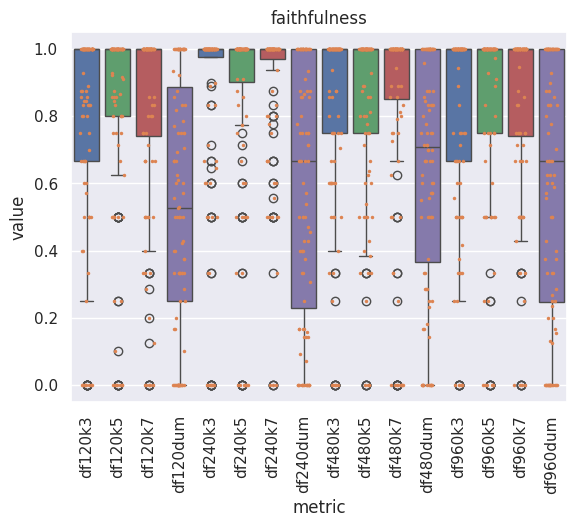

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


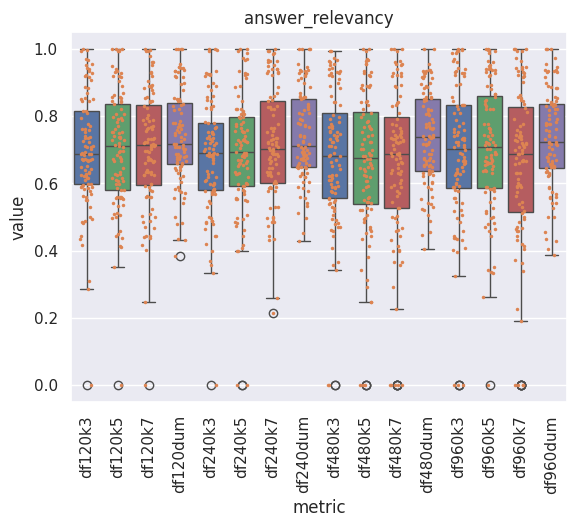

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


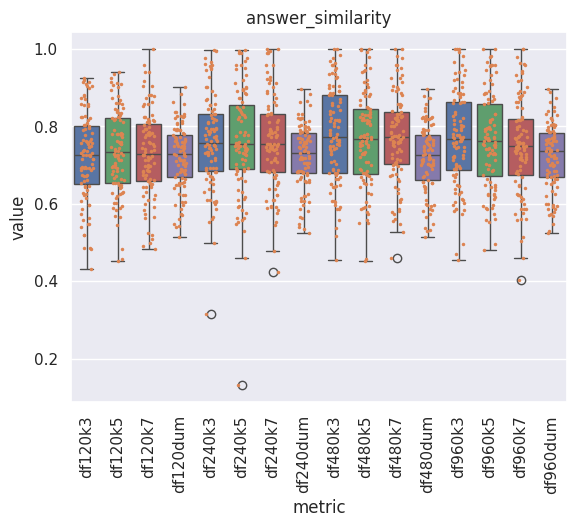

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


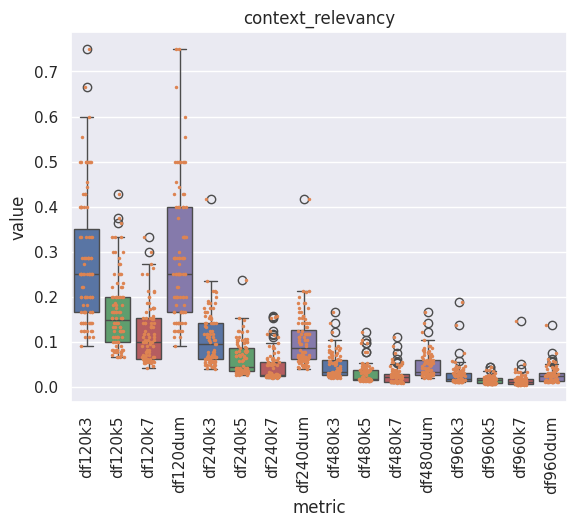

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


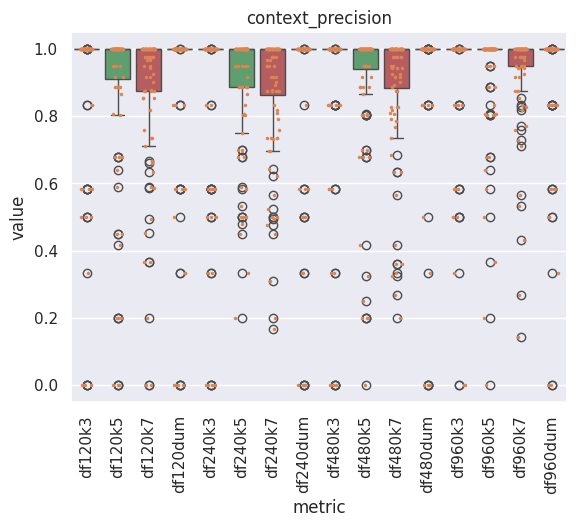

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


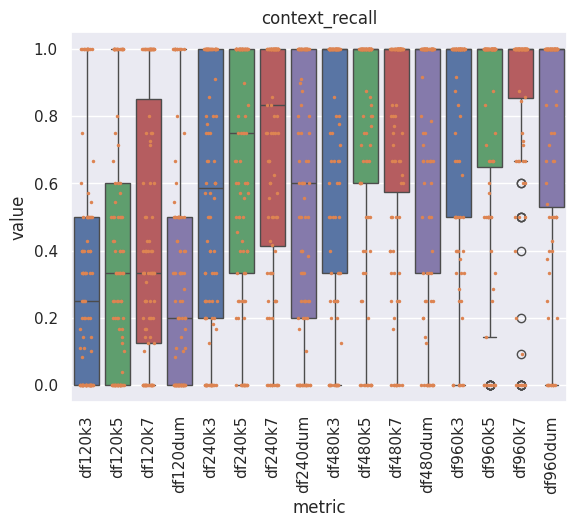

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


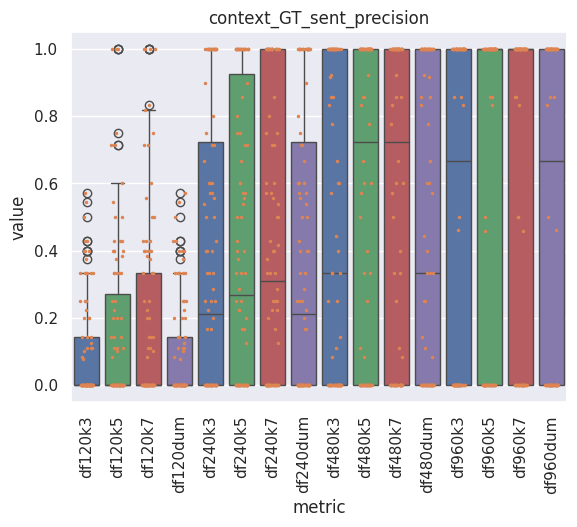

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


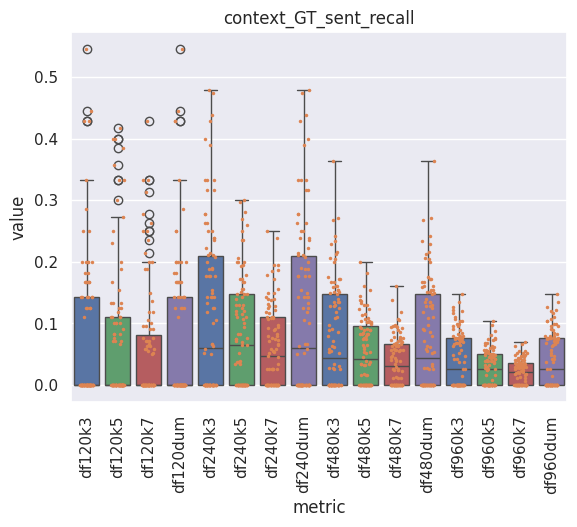

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


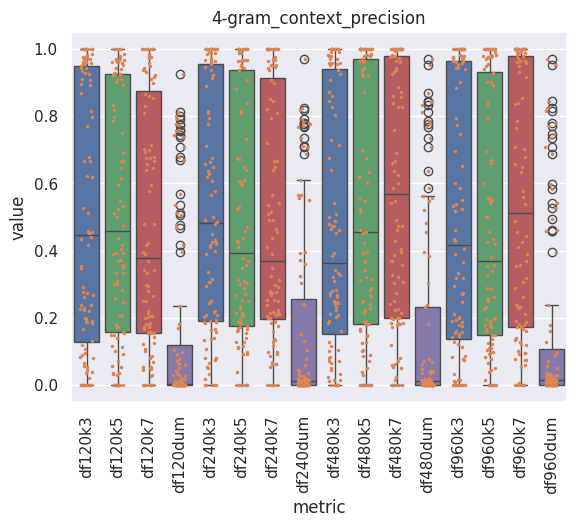

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


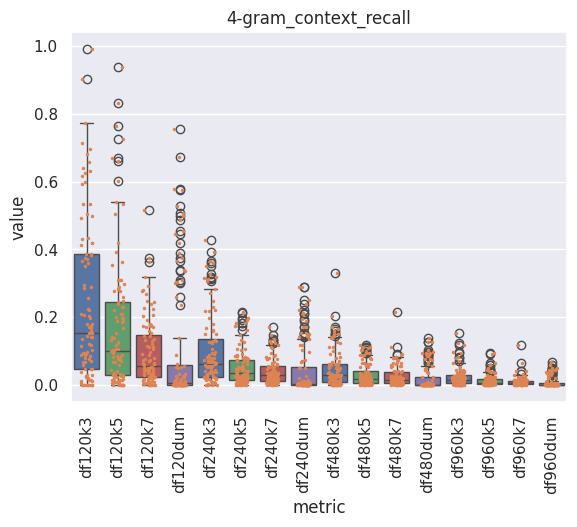

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


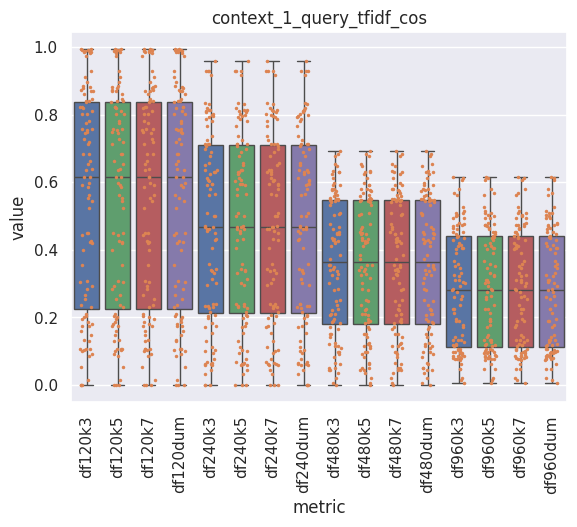

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


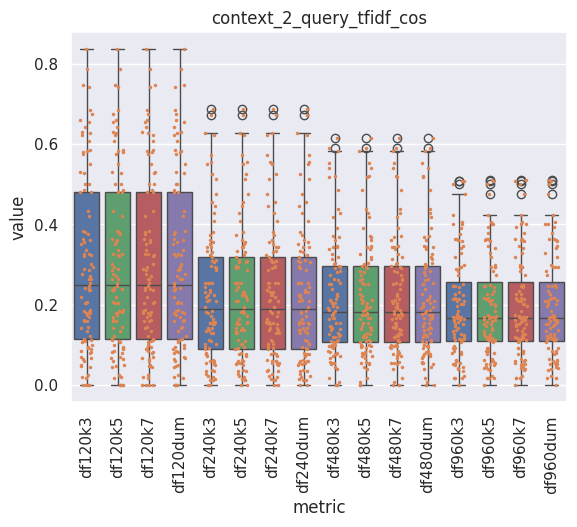

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


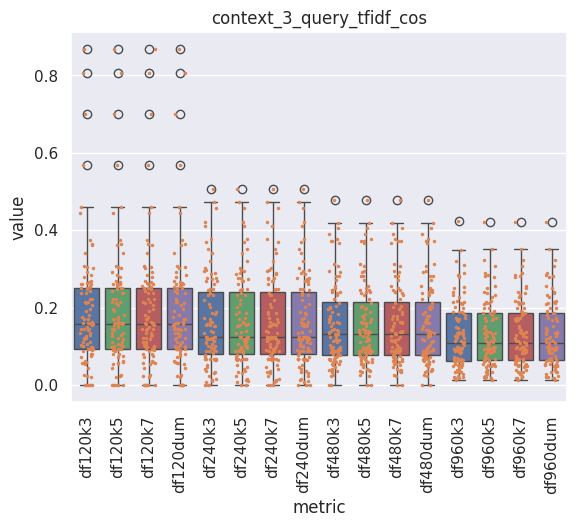

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


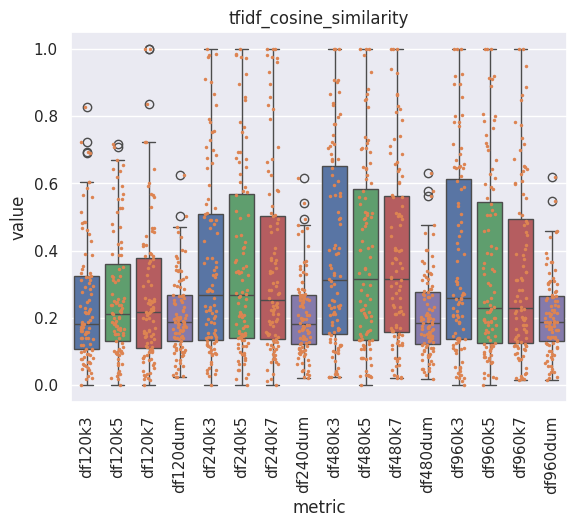

In [121]:
for x in df120dum.columns[4:]:
    box_plot(full_monty, x)

In [122]:
QA_stats = []
passage_stats = []
misleading_q_stats = []

for i in full_monty:
    passage_df = i[0:60]
    passage_df.name = i.name
    QA_df = i[60:91]
    QA_df.name = i.name
    misleading_q_df = i[91:]
    misleading_q_df.name = i.name
    passage_stats.append(passage_df)
    QA_stats.append(QA_df)
    misleading_q_stats.append(misleading_q_df)

# sanity check
print(passage_stats[0].shape, QA_stats[0].shape, misleading_q_stats[0].shape)

(60, 18) (31, 18) (5, 18)


Question & Answer


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


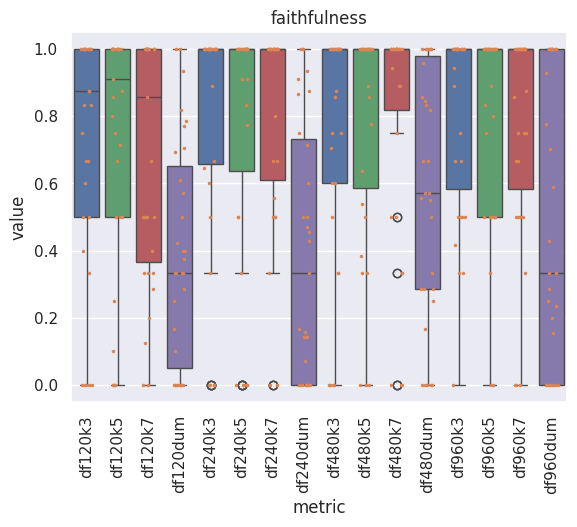

Passage Continuation


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


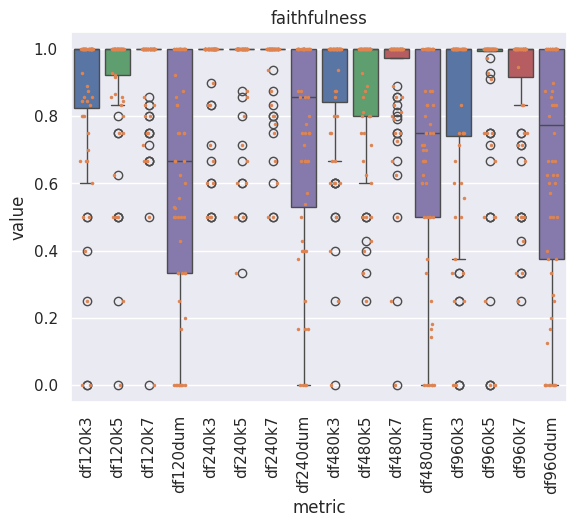

Misleading Questions


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


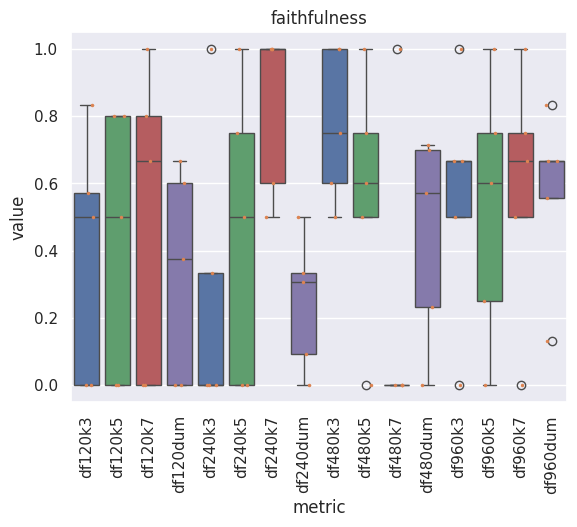

Question & Answer


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


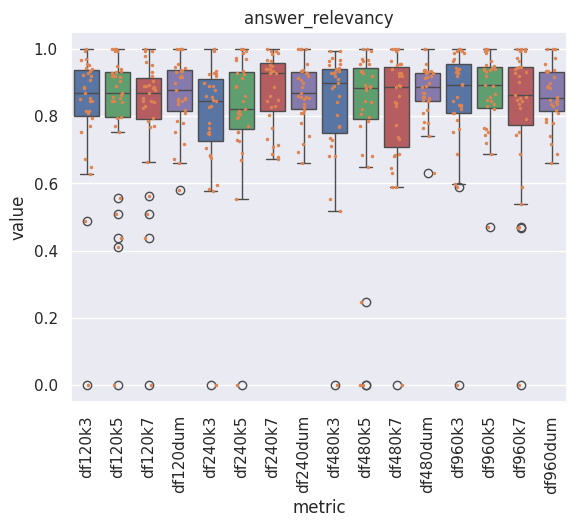

Passage Continuation


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


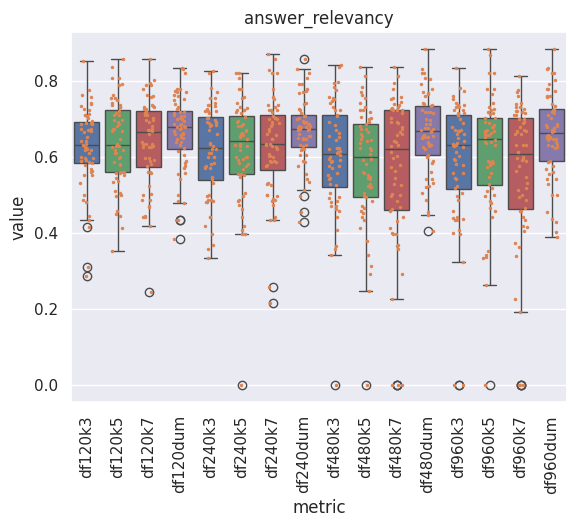

Misleading Questions


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


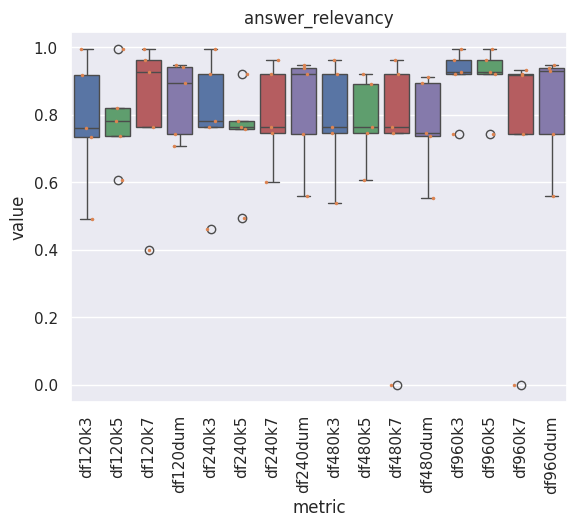

Question & Answer


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


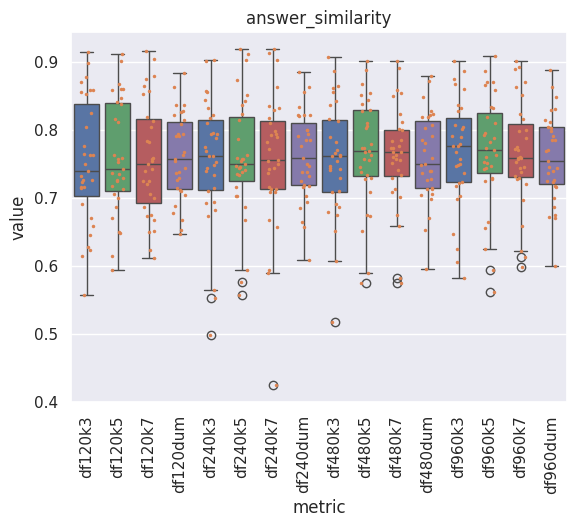

Passage Continuation


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


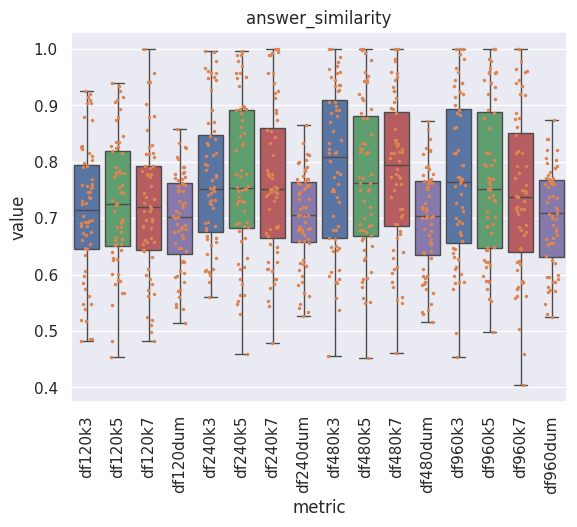

Misleading Questions


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


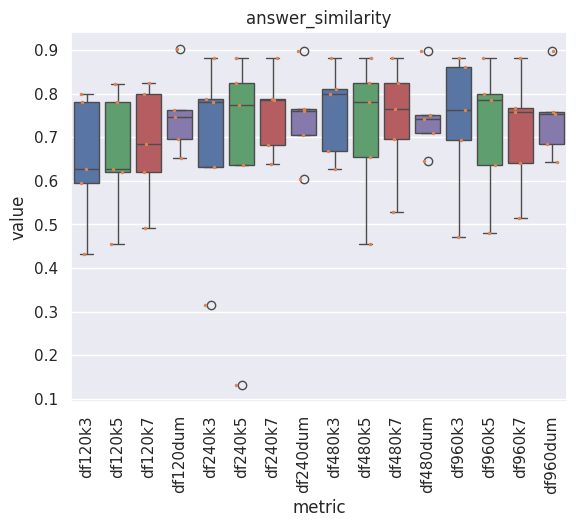

Question & Answer


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


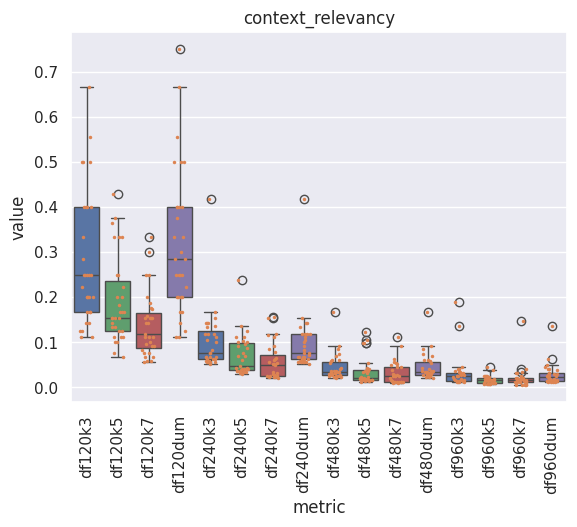

Passage Continuation


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


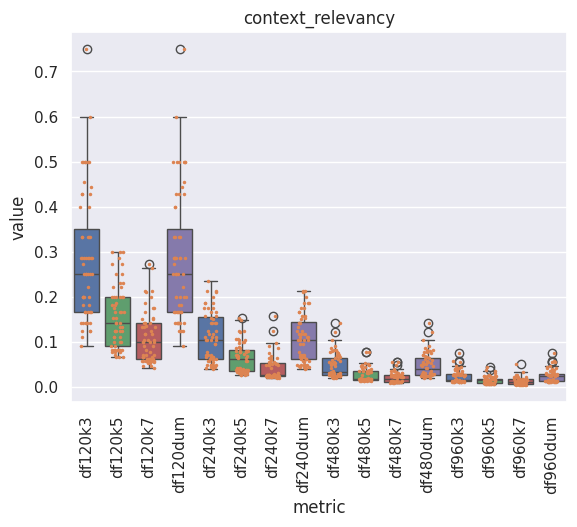

Misleading Questions


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


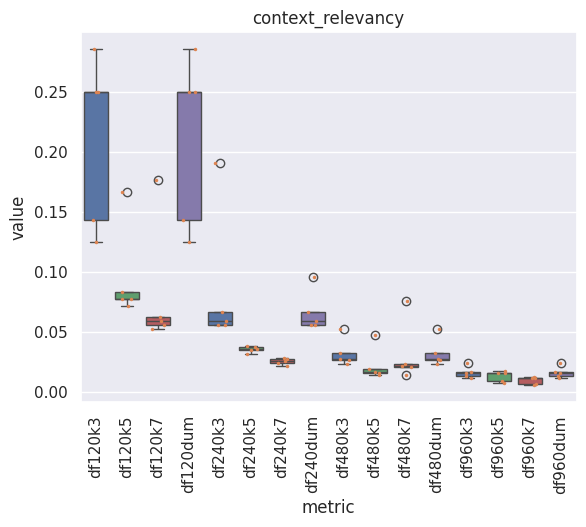

Question & Answer


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


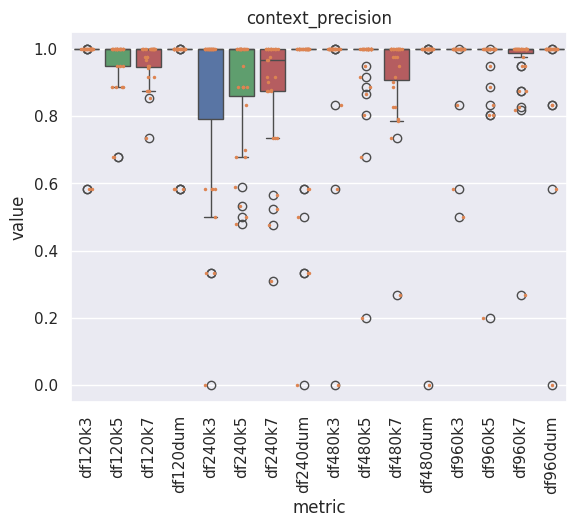

Passage Continuation


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


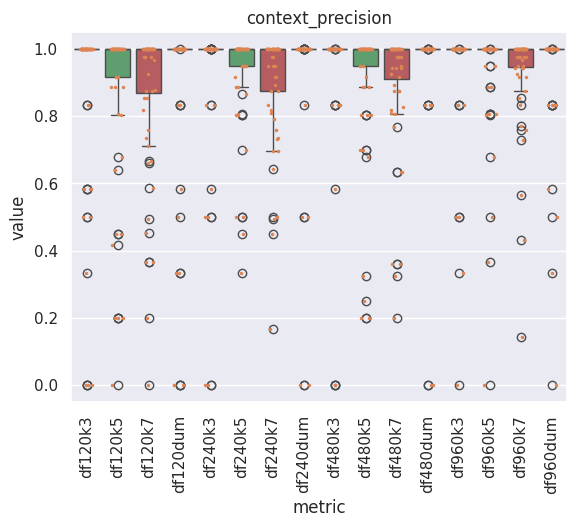

Misleading Questions


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


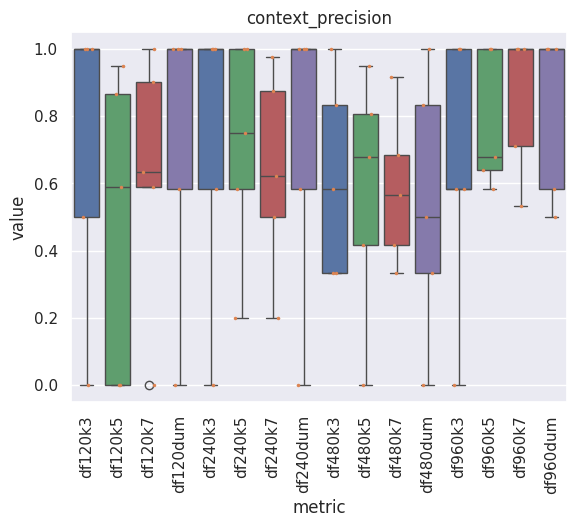

Question & Answer


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


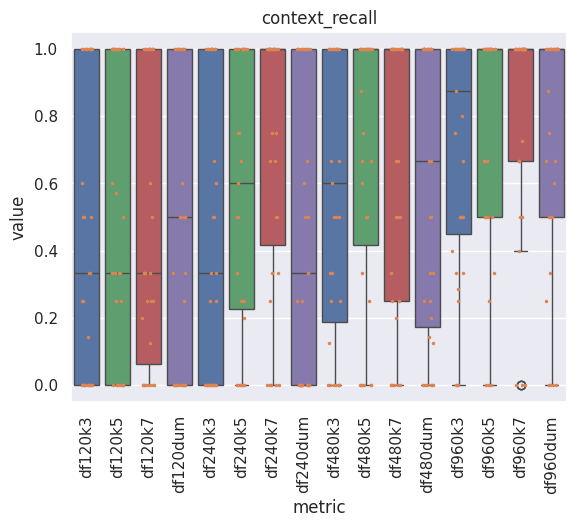

Passage Continuation


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


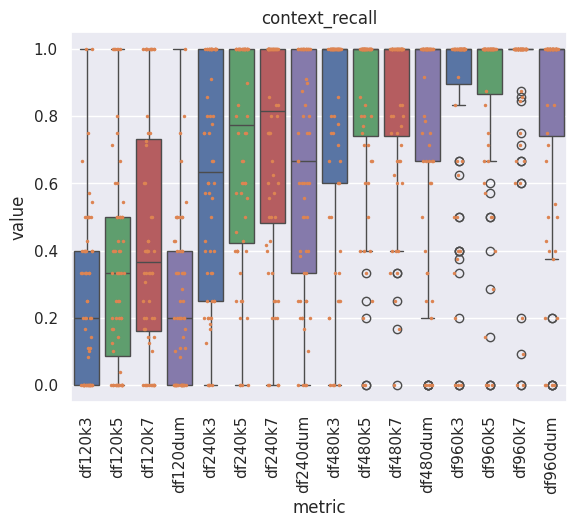

Misleading Questions


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


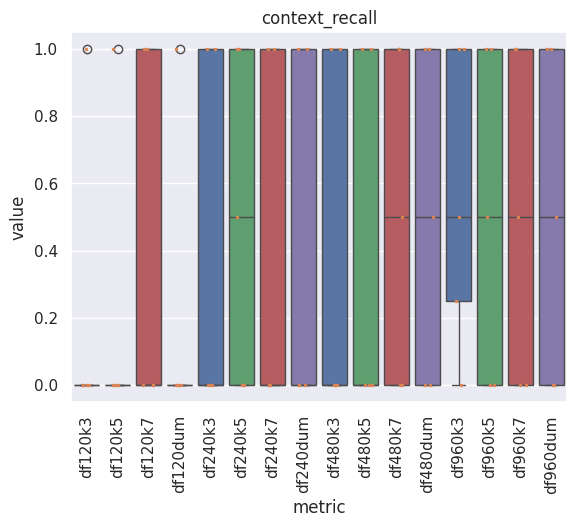

Question & Answer


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


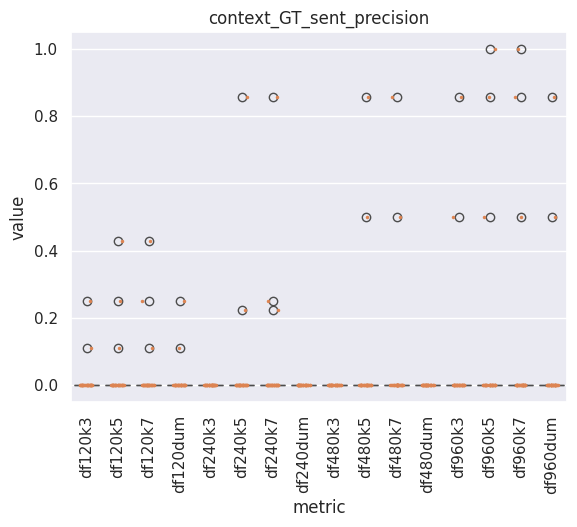

Passage Continuation


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


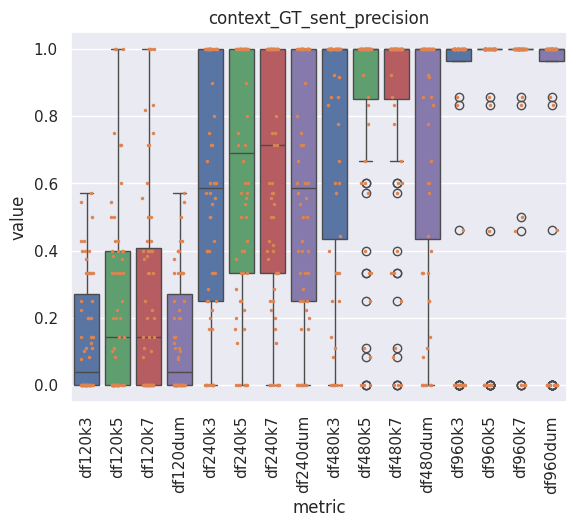

Misleading Questions


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


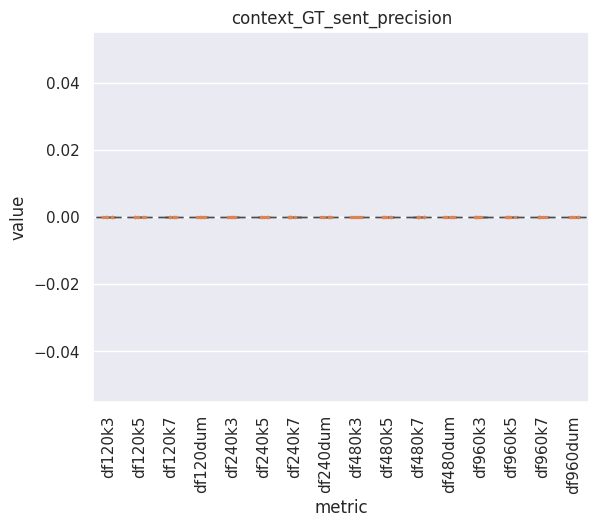

Question & Answer


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


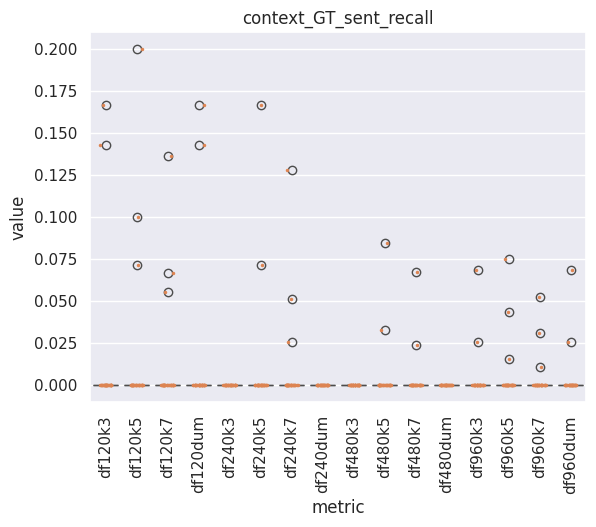

Passage Continuation


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


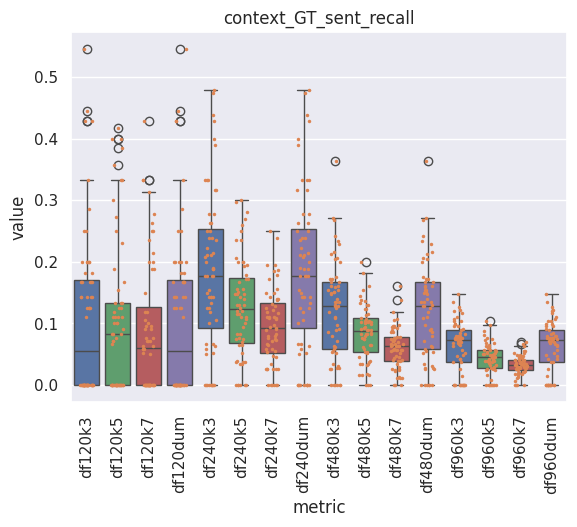

Misleading Questions


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


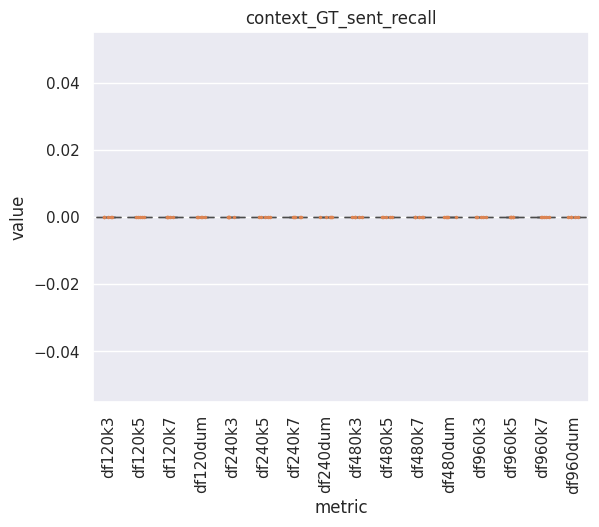

Question & Answer


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


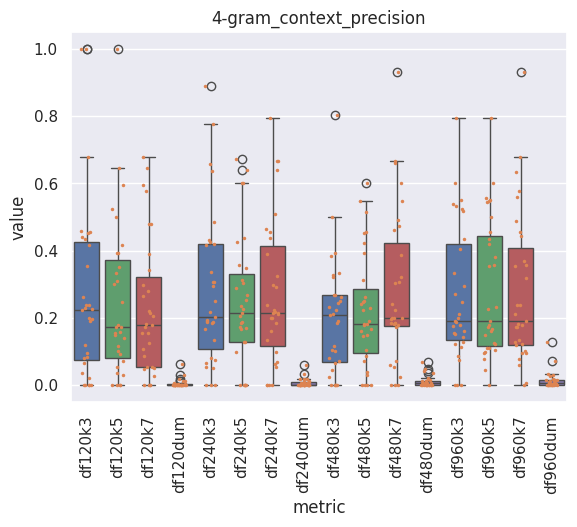

Passage Continuation


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


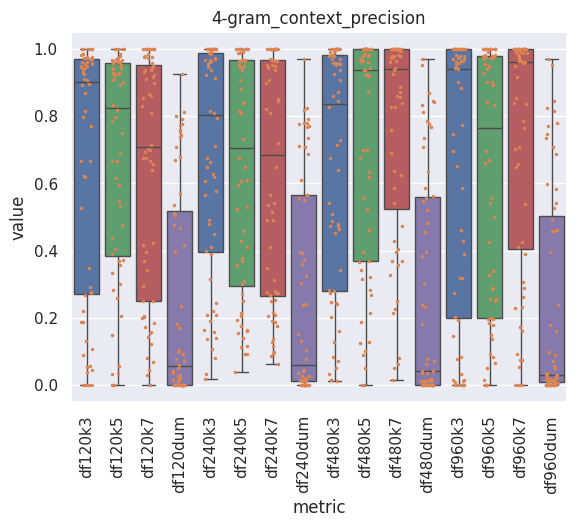

Misleading Questions


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


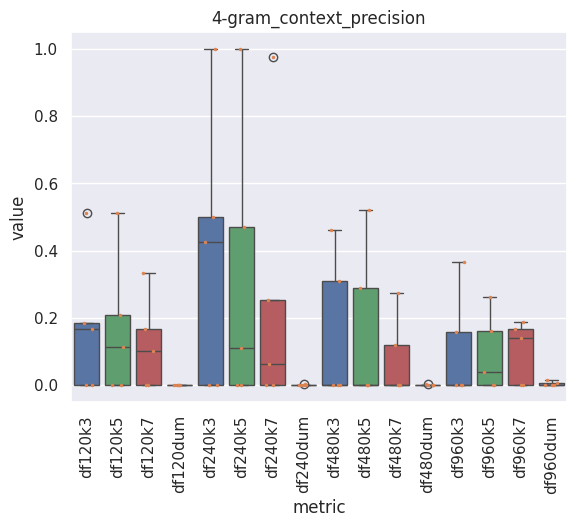

Question & Answer


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


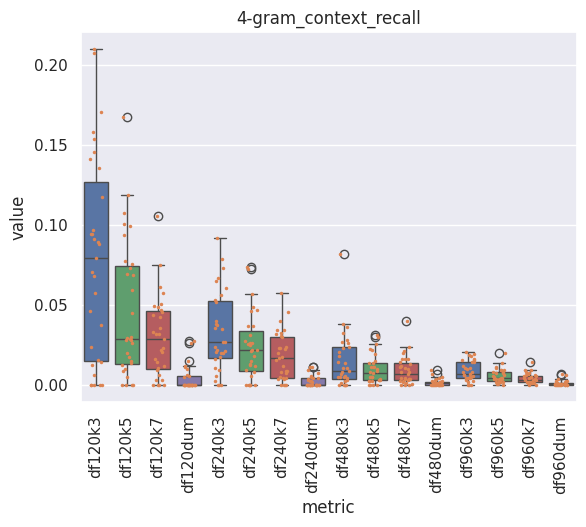

Passage Continuation


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


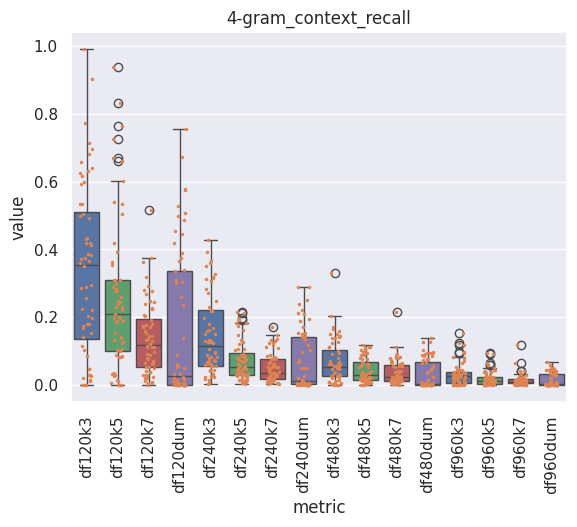

Misleading Questions


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


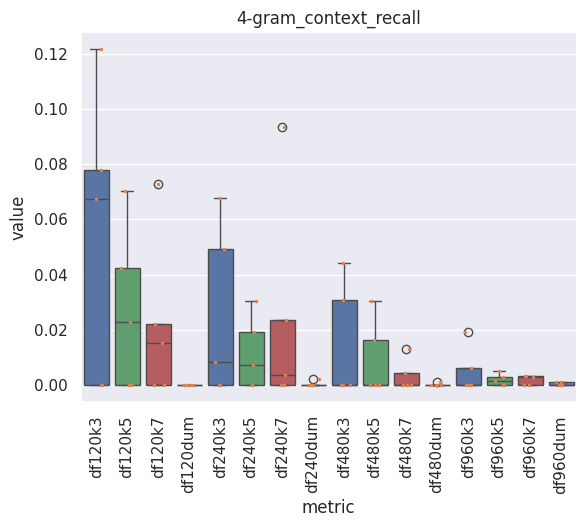

Question & Answer


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


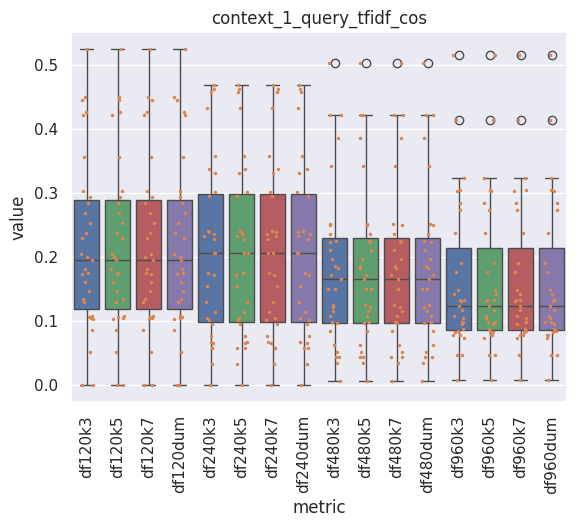

Passage Continuation


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


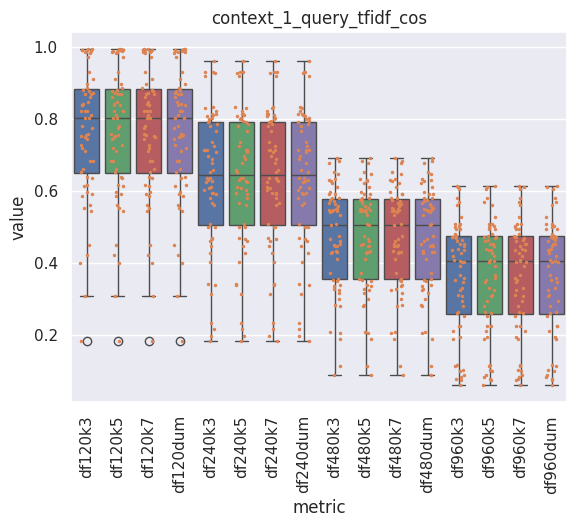

Misleading Questions


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


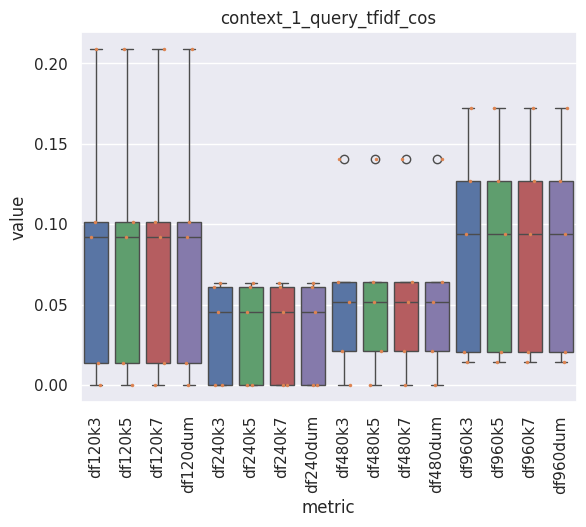

Question & Answer


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


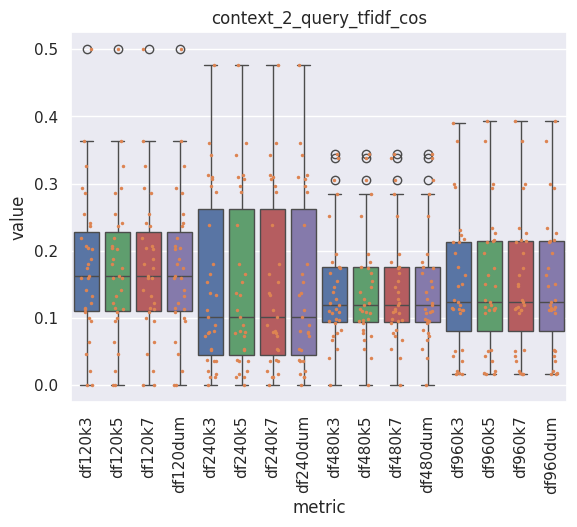

Passage Continuation


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


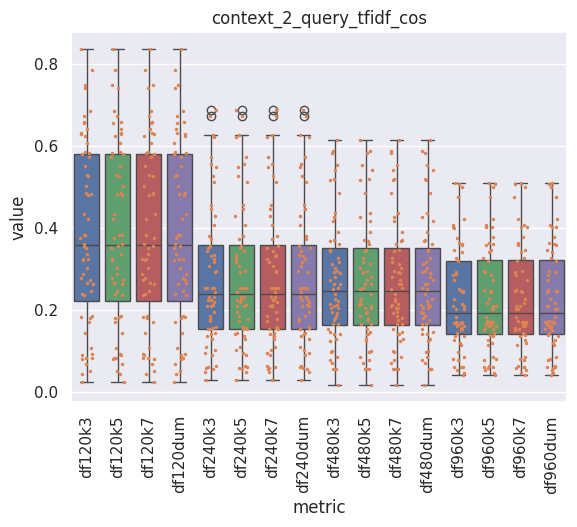

Misleading Questions


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


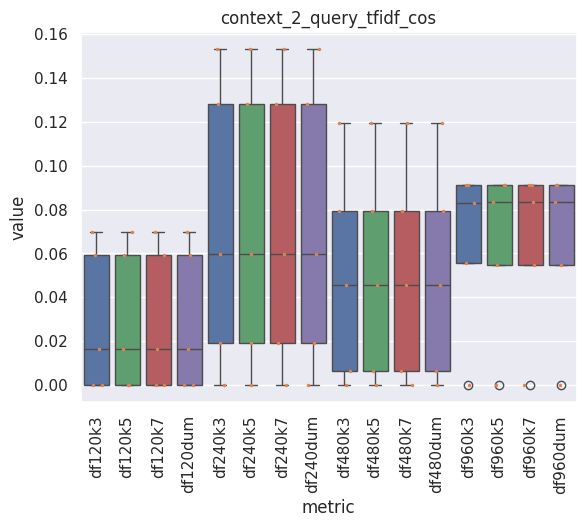

Question & Answer


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


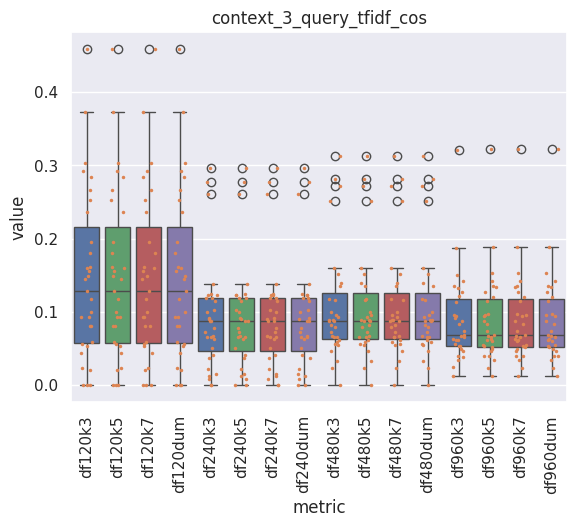

Passage Continuation


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


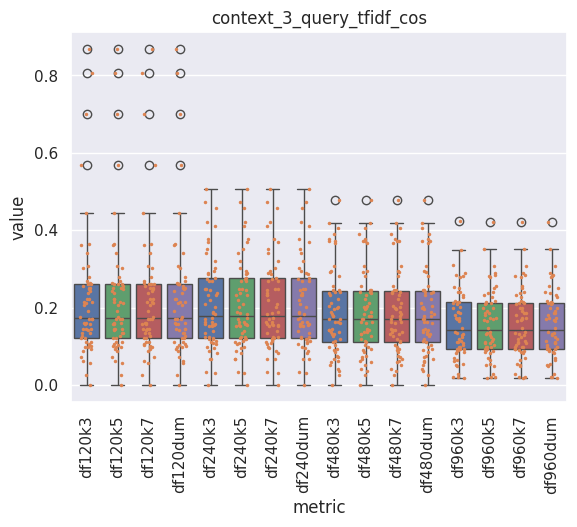

Misleading Questions


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


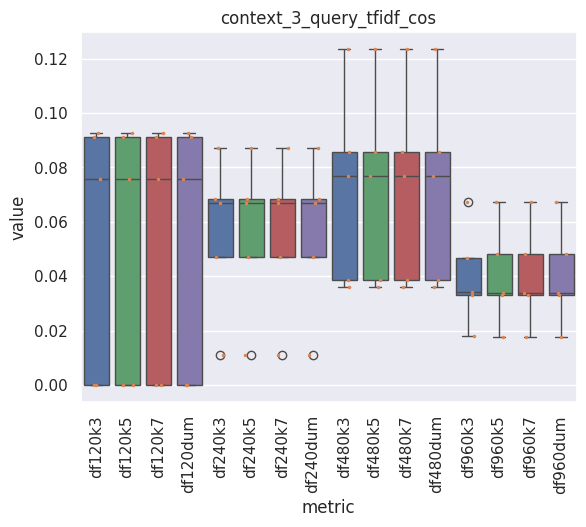

Question & Answer


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


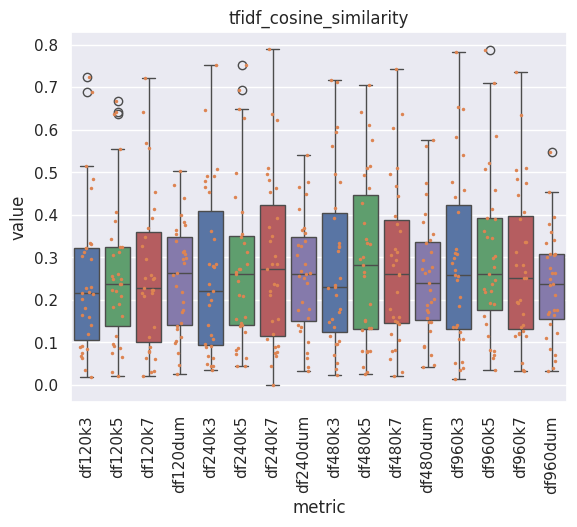

Passage Continuation


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


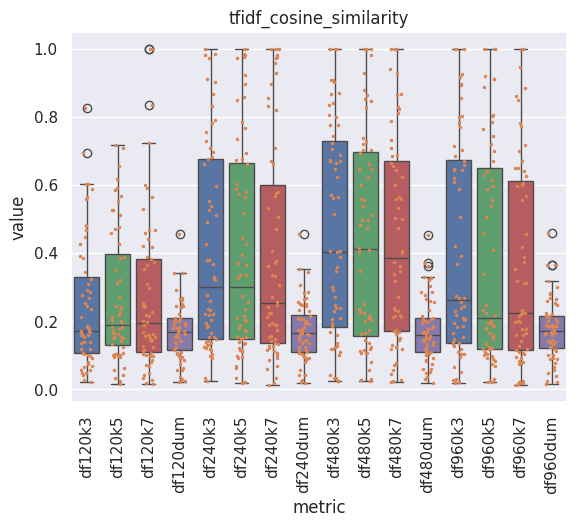

Misleading Questions


/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


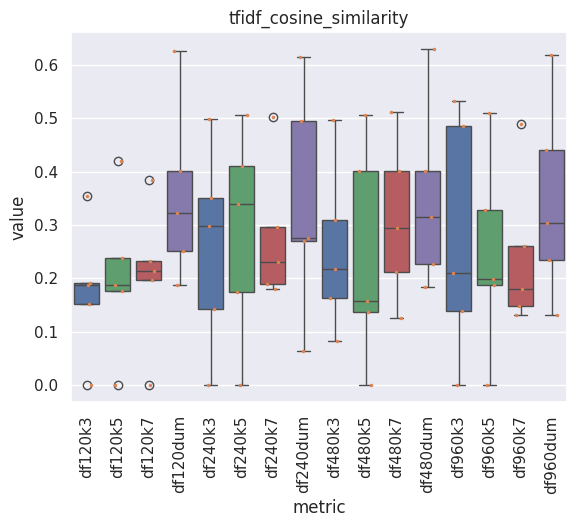

In [123]:
for i in df120dum.columns[4:]:
    print("Question & Answer")
    box_plot(QA_stats, i)
    print("Passage Continuation")
    box_plot(passage_stats, i)
    print("Misleading Questions")
    box_plot(misleading_q_stats, i)

### Similarity Correlation

1
(192,)
(192, 1626)
['10' '102' '11' ... 'α2' 'β1' 'σíαλoν']
(96, 96)
2
(192,)
(192, 1664)
['025' '03' '10' ... 'α2' 'β1' 'σíαλoν']
(96, 96)
3
(192,)
(192, 1711)
['10' '102' '13' ... 'α2' 'β1' 'σíαλoν']
(96, 96)
4
(192,)
(192, 1795)
['025' '03' '10' ... 'α2' 'β1' 'σíαλoν']
(96, 96)
5
(192,)
(192, 1892)
['025' '03' '10' ... 'α2' 'β1' 'σíαλoν']
(96, 96)
(192,)
(192, 3467)
['000' '10' '1000' ... 'α4glcnac' 'β1' 'β4galnac']
(96, 96)
PearsonRResult(statistic=0.16043960101719223, pvalue=0.3885852526891407)
SignificanceResult(statistic=0.18391617561502685, pvalue=0.3219770977654912)


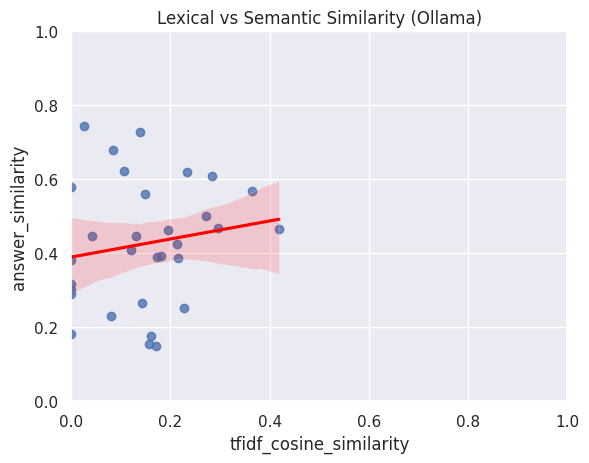

In [124]:
ollama = pd.read_csv('./results/ollama-4/ragas_curated.csv')
ollama = custom_metrics(ollama)
ollamaQA = ollama[60:91]
ollamaQA.name = 'ollamaQA'

# correlation plot
plot = sns.regplot(x='tfidf_cosine_similarity', y='answer_similarity', data=ollamaQA, line_kws={'color':'red'})
plot.set(title='Lexical vs Semantic Similarity (Ollama)')
plt.xlim(0, 1)
plt.ylim(0, 1)
print(pearsonr(ollamaQA['tfidf_cosine_similarity'], ollamaQA['answer_similarity']))
print(spearmanr(ollamaQA['tfidf_cosine_similarity'], ollamaQA['answer_similarity']))
plt.show()

PearsonRResult(statistic=0.6613912538848278, pvalue=5.098833534986371e-05)
SignificanceResult(statistic=0.6758064516129033, pvalue=3.017872657358296e-05)


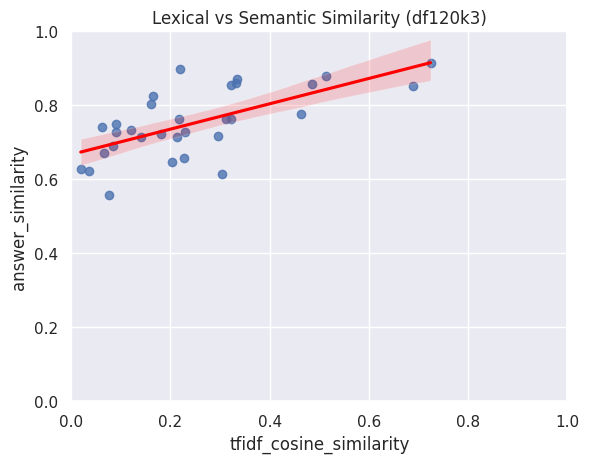

PearsonRResult(statistic=0.5616904572225788, pvalue=0.0010090570875055701)
SignificanceResult(statistic=0.5161290322580646, pvalue=0.0029567259704205064)


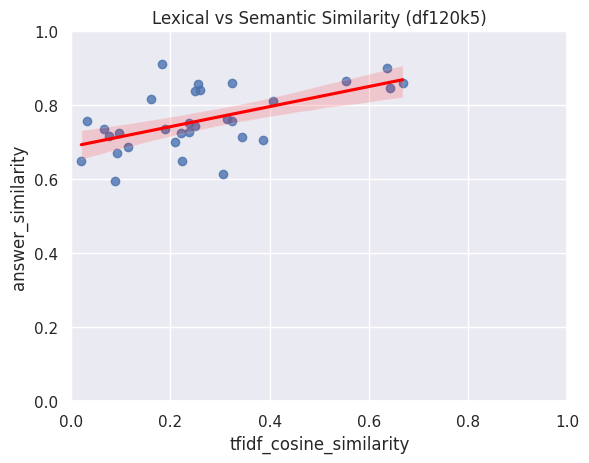

PearsonRResult(statistic=0.5870233610547899, pvalue=0.0005177474249831157)
SignificanceResult(statistic=0.5625, pvalue=0.0009885776702318481)


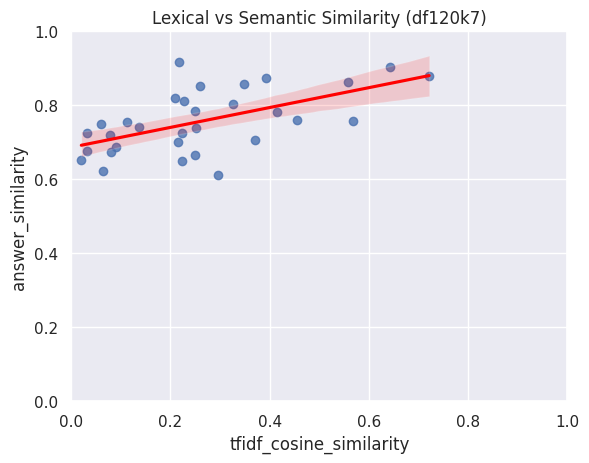

PearsonRResult(statistic=0.7315660981243265, pvalue=2.929499516721e-06)
SignificanceResult(statistic=0.7346774193548389, pvalue=2.5295107780101792e-06)


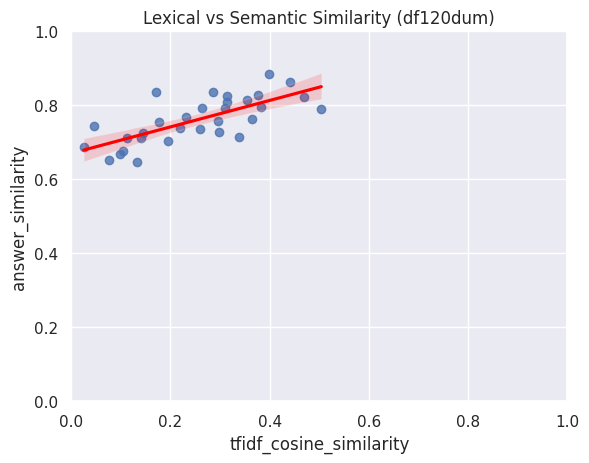

PearsonRResult(statistic=0.627657546753186, pvalue=0.00015707939115522002)
SignificanceResult(statistic=0.6971774193548388, pvalue=1.3126325533015808e-05)


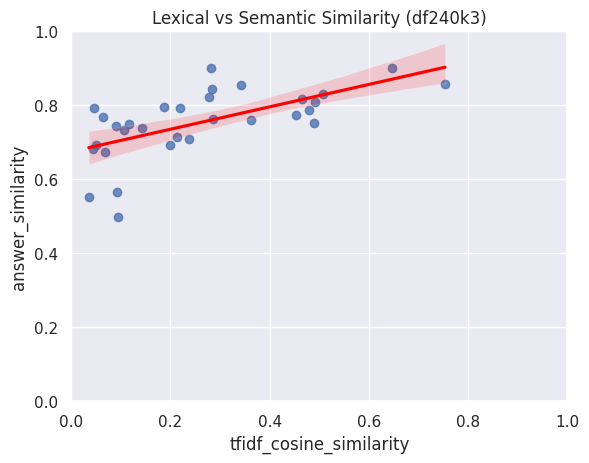

PearsonRResult(statistic=0.6486030839716466, pvalue=7.937124220181166e-05)
SignificanceResult(statistic=0.6362903225806452, pvalue=0.0001192802371147856)


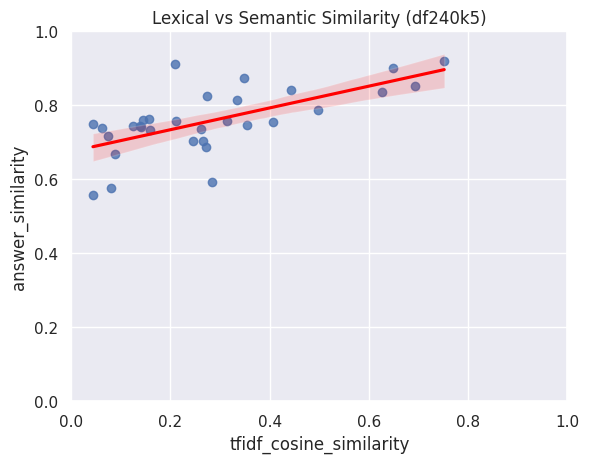

PearsonRResult(statistic=0.6304541707518592, pvalue=0.0001438076531417363)
SignificanceResult(statistic=0.6786290322580647, pvalue=2.7141863544367876e-05)


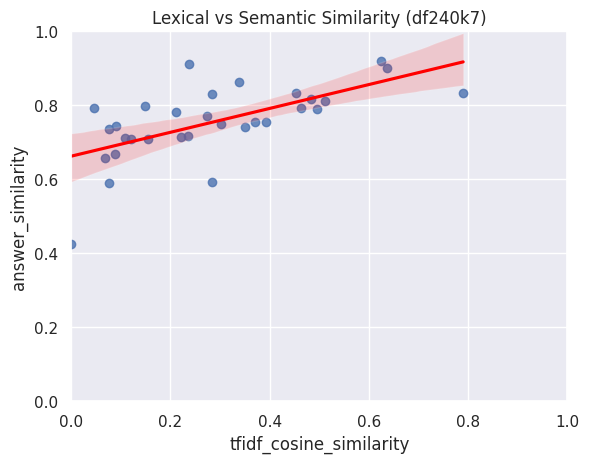

PearsonRResult(statistic=0.7221044830974226, pvalue=4.523466110341551e-06)
SignificanceResult(statistic=0.7129032258064517, pvalue=6.789174788259863e-06)


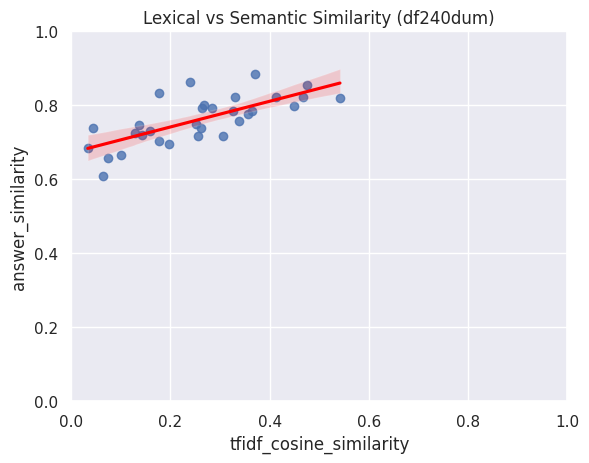

PearsonRResult(statistic=0.7264604616951482, pvalue=3.7116035931915827e-06)
SignificanceResult(statistic=0.7806451612903227, pvalue=2.2180320220159952e-07)


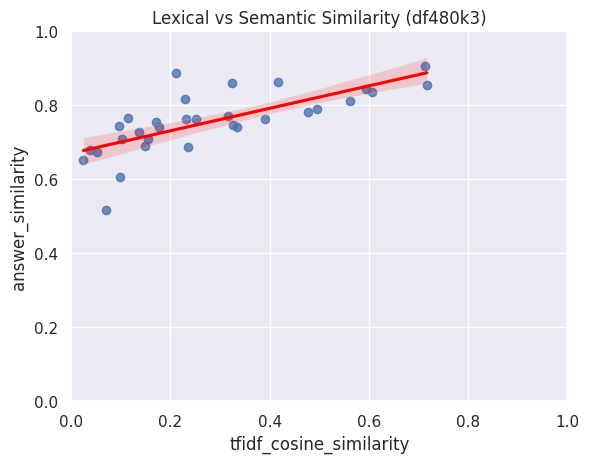

PearsonRResult(statistic=0.7484279353659663, pvalue=1.2895212068337146e-06)
SignificanceResult(statistic=0.822983870967742, pvalue=1.3264543258875202e-08)


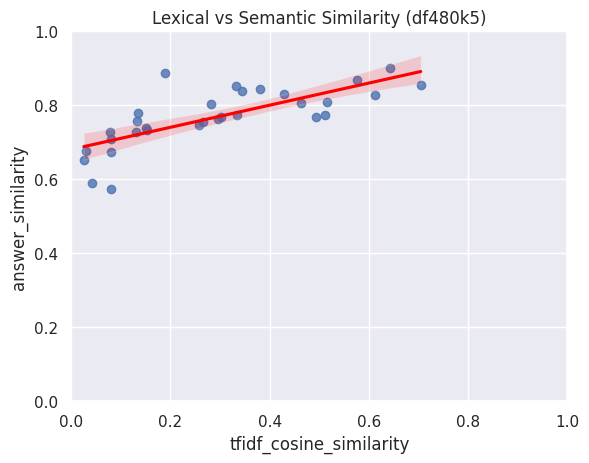

PearsonRResult(statistic=0.6062700589166548, pvalue=0.0003002678844293904)
SignificanceResult(statistic=0.6963709677419355, pvalue=1.3562596171927883e-05)


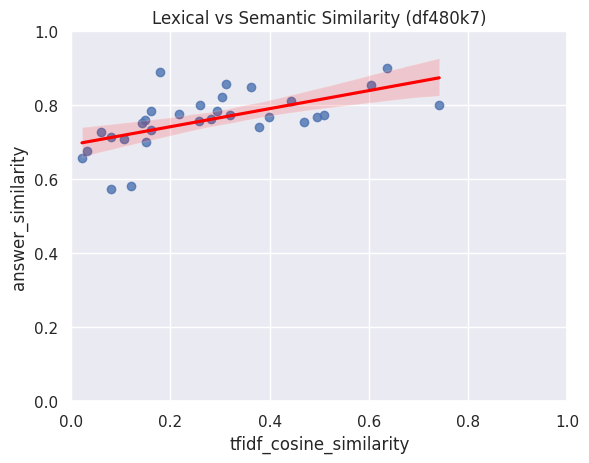

PearsonRResult(statistic=0.7028930299973085, pvalue=1.0379638487149458e-05)
SignificanceResult(statistic=0.7229838709677421, pvalue=4.347668072764423e-06)


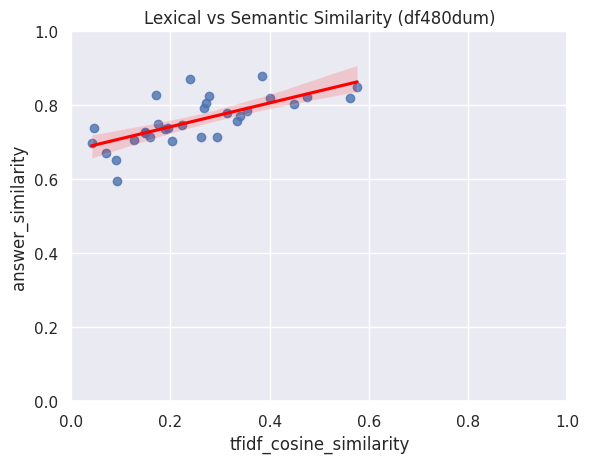

PearsonRResult(statistic=0.677247855884133, pvalue=2.8591740914866065e-05)
SignificanceResult(statistic=0.7520161290322581, pvalue=1.0740156037267807e-06)


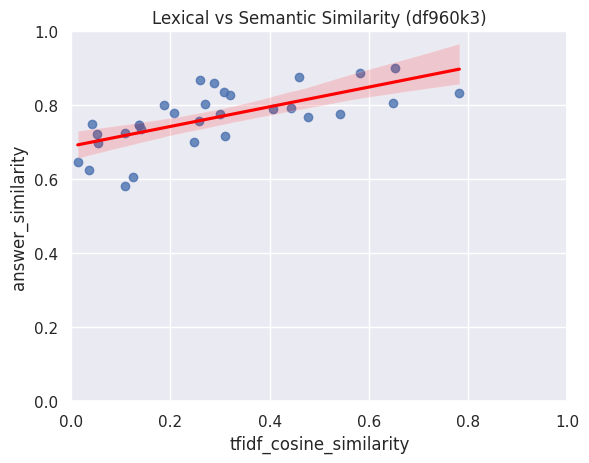

PearsonRResult(statistic=0.6212473735820263, pvalue=0.0001916955932642164)
SignificanceResult(statistic=0.6733870967741936, pvalue=3.3021113355426216e-05)


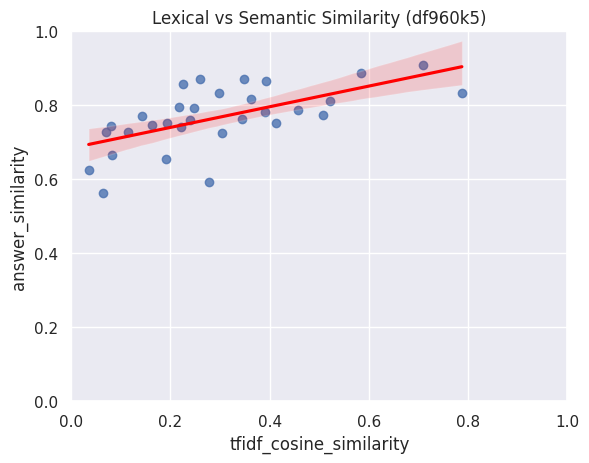

PearsonRResult(statistic=0.6086708207781493, pvalue=0.00027984988662074317)
SignificanceResult(statistic=0.7294354838709678, pvalue=3.2356094994720034e-06)


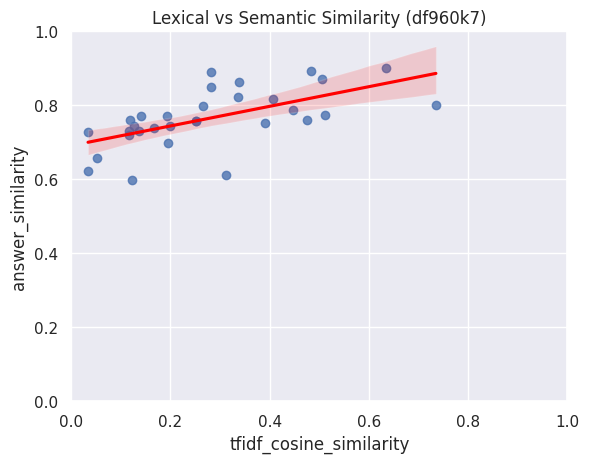

PearsonRResult(statistic=0.7281151848033761, pvalue=3.4395635379282056e-06)
SignificanceResult(statistic=0.7500000000000001, pvalue=1.1906826558765666e-06)


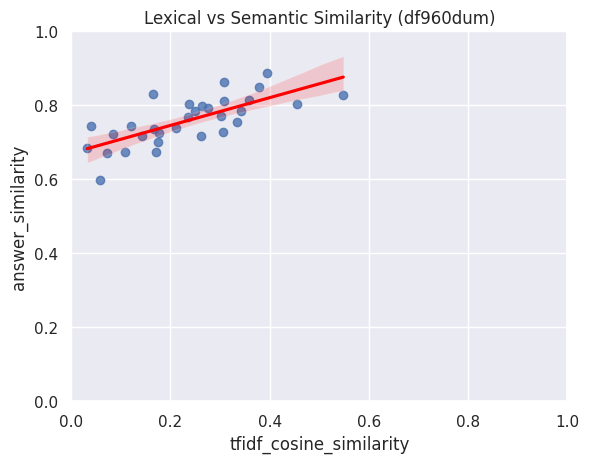

In [125]:
# correlation plot
def correlation_plot(df: pd.DataFrame, title=None):
    if title is None:
        title = df.name
    plot = sns.regplot(x='tfidf_cosine_similarity', y='answer_similarity', data=df, line_kws={'color':'red'})
    plot.set(title=f'Lexical vs Semantic Similarity ({title})')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    print(pearsonr(df['tfidf_cosine_similarity'], df['answer_similarity']))
    print(spearmanr(df['tfidf_cosine_similarity'], df['answer_similarity']))
    plt.show()

for i in QA_stats:
    correlation_plot(i)

# Specific Charts for Final Presentation

In [126]:
# line plot of average context relevance across k chunks
k7 = [QA_stats[2], QA_stats[6], QA_stats[10], QA_stats[14]]
k7_slice_cols = [f"context_{k}_query_tfidf_cos" for k in range(1, 8)]
k7_means = {'df120k7':[], 
            'df240k7':[], 
            'df480k7':[], 
            'df960k7':[]}
for i in k7:
    for k in k7_slice_cols:
        k7_means[i.name].append(i[k].mean())

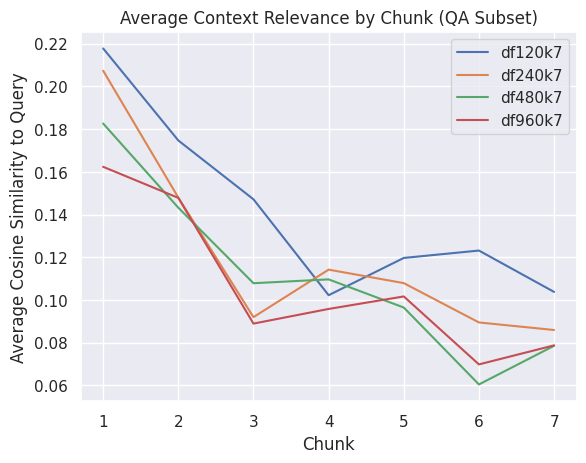

In [127]:
sns.lineplot(x=range(1, 8), y=k7_means['df120k7'], label='df120k7')
sns.lineplot(x=range(1, 8), y=k7_means['df240k7'], label='df240k7')
sns.lineplot(x=range(1, 8), y=k7_means['df480k7'], label='df480k7')
sns.lineplot(x=range(1, 8), y=k7_means['df960k7'], label='df960k7')
plt.title('Average Context Relevance by Chunk (QA Subset)')
plt.xlabel('Chunk')
plt.ylabel('Average Cosine Similarity to Query')
plt.show()

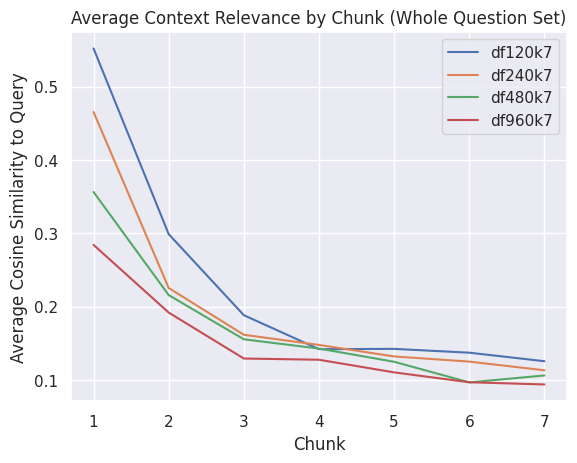

In [128]:
# line plot of average context relevance across k chunks
k7 = [full_monty[2], full_monty[6], full_monty[10], full_monty[14]]
k7_slice_cols = [f"context_{k}_query_tfidf_cos" for k in range(1, 8)]
k7_means = {'df120k7':[], 
            'df240k7':[], 
            'df480k7':[], 
            'df960k7':[]}
for i in k7:
    for k in k7_slice_cols:
        k7_means[i.name].append(i[k].mean())

sns.lineplot(x=range(1, 8), y=k7_means['df120k7'], label='df120k7')
sns.lineplot(x=range(1, 8), y=k7_means['df240k7'], label='df240k7')
sns.lineplot(x=range(1, 8), y=k7_means['df480k7'], label='df480k7')
sns.lineplot(x=range(1, 8), y=k7_means['df960k7'], label='df960k7')
plt.title('Average Context Relevance by Chunk (Whole Question Set)')
plt.xlabel('Chunk')
plt.ylabel('Average Cosine Similarity to Query')
plt.show()

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


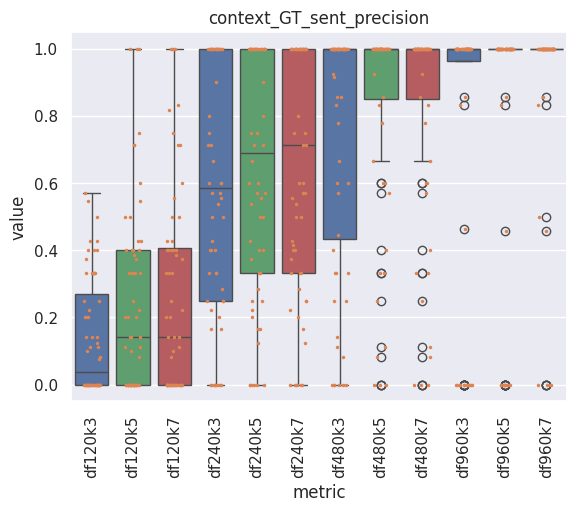

In [133]:
# sentence retrieval on Continuation Questions
trials = [df for i, df in enumerate(passage_stats, start=1) if i % 4 != 0]
box_plot(trials, 'context_GT_sent_precision')

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


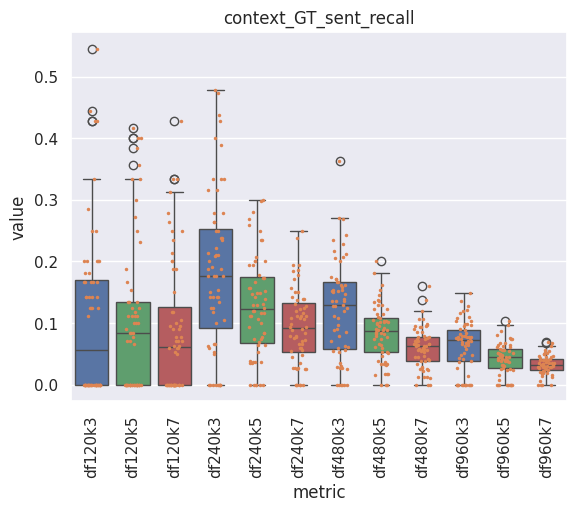

In [134]:
box_plot(trials, 'context_GT_sent_recall')

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


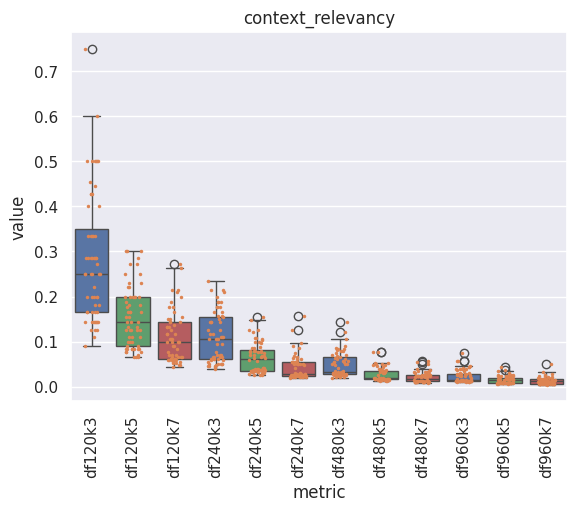

/tmp/ipykernel_68296/2372262924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


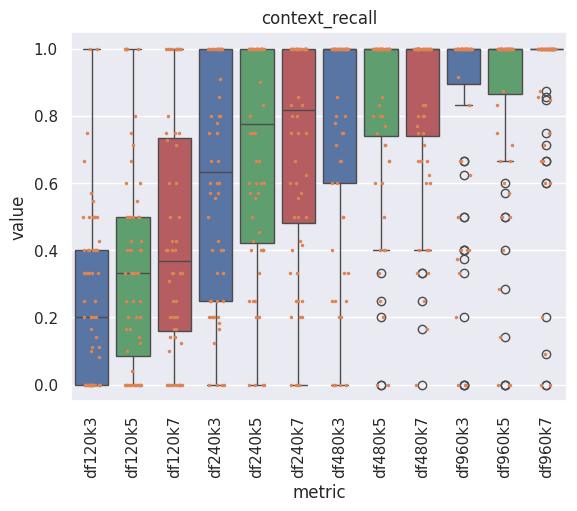

In [137]:
box_plot(trials, 'context_relevancy')
box_plot(trials, 'context_recall')

PearsonRResult(statistic=0.7484279353659663, pvalue=1.2895212068337146e-06)
SignificanceResult(statistic=0.822983870967742, pvalue=1.3264543258875202e-08)


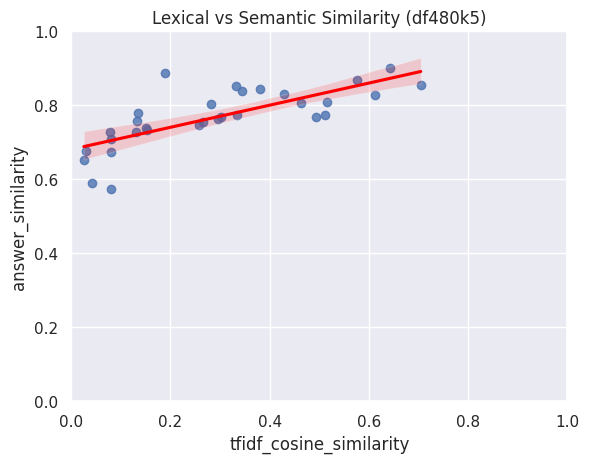

count    31.000000
mean      0.767997
std       0.079510
min       0.573993
25%       0.731649
50%       0.769028
75%       0.828972
max       0.901288
Name: answer_similarity, dtype: float64
count    31.000000
mean      0.291867
std       0.198955
min       0.025374
25%       0.131775
50%       0.282106
75%       0.446401
max       0.704515
Name: tfidf_cosine_similarity, dtype: float64
PearsonRResult(statistic=0.5616904572225788, pvalue=0.0010090570875055701)
SignificanceResult(statistic=0.5161290322580646, pvalue=0.0029567259704205064)


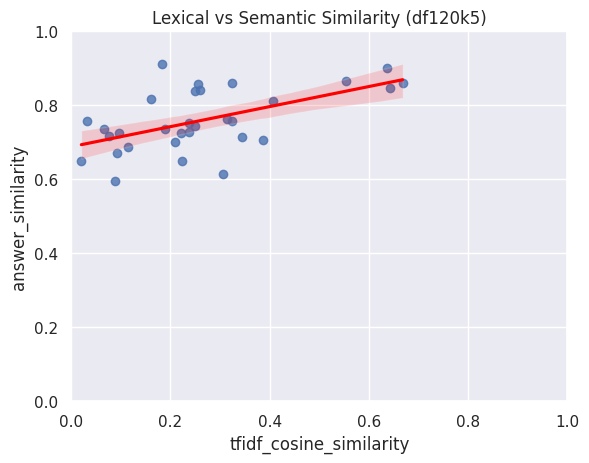

count    31.000000
mean      0.759446
std       0.084221
min       0.594034
25%       0.709339
50%       0.742806
75%       0.839594
max       0.912375
Name: answer_similarity, dtype: float64
count    31.000000
mean      0.263406
std       0.174359
min       0.020294
25%       0.137981
50%       0.237859
75%       0.324110
max       0.668019
Name: tfidf_cosine_similarity, dtype: float64
PearsonRResult(statistic=0.16043960101719223, pvalue=0.3885852526891407)
SignificanceResult(statistic=0.18391617561502685, pvalue=0.3219770977654912)


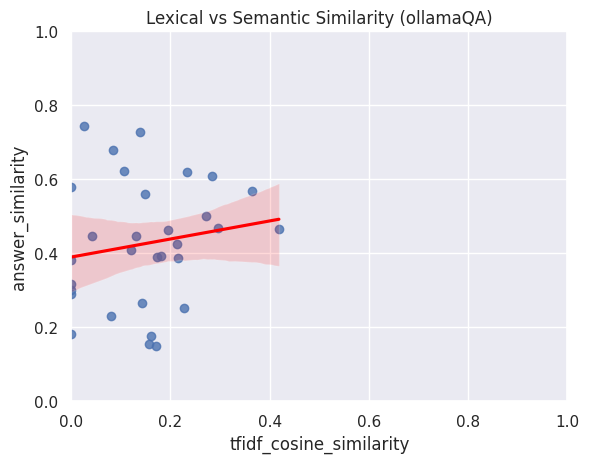

count    31.000000
mean      0.425500
std       0.169386
min       0.148678
25%       0.294032
50%       0.425064
75%       0.564766
max       0.745315
Name: answer_similarity, dtype: float64
count    31.000000
mean      0.147710
std       0.111226
min       0.000000
25%       0.061520
50%       0.147737
75%       0.214246
max       0.418671
Name: tfidf_cosine_similarity, dtype: float64


In [140]:
dfhigh_corr = QA_stats[9]
dfmed_corr = QA_stats[1]
stats = [dfhigh_corr, dfmed_corr, ollamaQA]
for i in stats:
    correlation_plot(i)
    print(i['answer_similarity'].describe())
    print(i['tfidf_cosine_similarity'].describe())

PearsonRResult(statistic=0.8364036286437551, pvalue=2.778102132675007e-26)
SignificanceResult(statistic=0.8417118827997828, pvalue=6.70973593767491e-27)


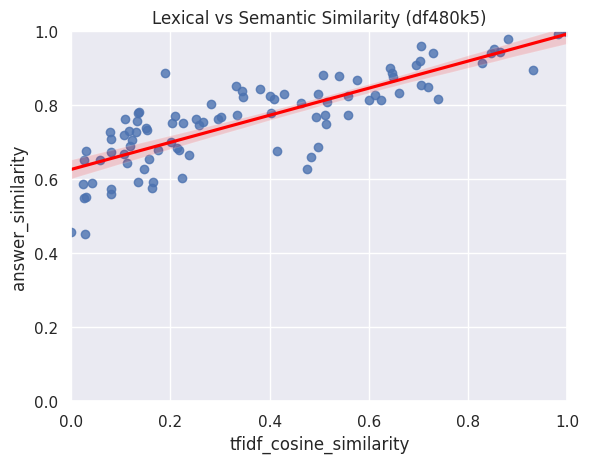

count    96.000000
mean      0.765506
std       0.122868
min       0.451947
25%       0.678128
50%       0.768526
75%       0.844974
max       1.000000
Name: answer_similarity, dtype: float64
count    96.000000
mean      0.379212
std       0.280605
min       0.000000
25%       0.134807
50%       0.316076
75%       0.582304
max       1.000000
Name: tfidf_cosine_similarity, dtype: float64
PearsonRResult(statistic=0.7028981244233283, pvalue=1.4296570084662714e-15)
SignificanceResult(statistic=0.7152333152468802, pvalue=2.6898995662102186e-16)


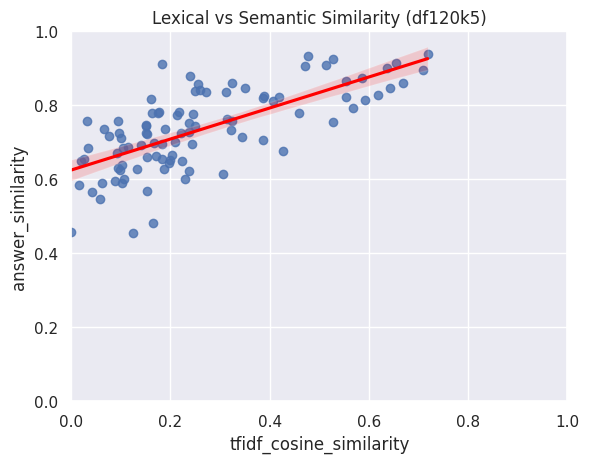

count    96.000000
mean      0.734844
std       0.109756
min       0.453326
25%       0.654576
50%       0.733703
75%       0.822834
max       0.939296
Name: answer_similarity, dtype: float64
count    96.000000
mean      0.262144
std       0.183918
min       0.000000
25%       0.130053
50%       0.211223
75%       0.359711
max       0.718512
Name: tfidf_cosine_similarity, dtype: float64
PearsonRResult(statistic=-0.023840447366606326, pvalue=0.8176561810618993)
SignificanceResult(statistic=-0.05610263980403567, pvalue=0.5871858692462988)


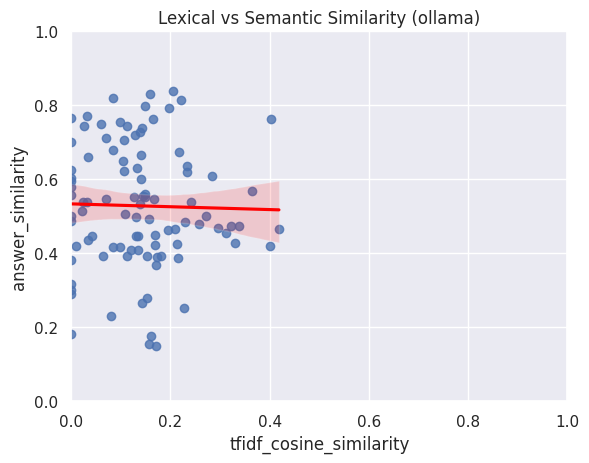

count    96.000000
mean      0.527963
std       0.166421
min       0.148678
25%       0.419575
50%       0.510034
75%       0.651358
max       0.838235
Name: answer_similarity, dtype: float64
count    96.000000
mean      0.138675
std       0.102787
min       0.000000
25%       0.062845
50%       0.138806
75%       0.195248
max       0.418671
Name: tfidf_cosine_similarity, dtype: float64


In [142]:
dfhigh_corr = full_monty[9]
dfmed_corr = full_monty[1]
ollama.name = 'ollama'
stats = [dfhigh_corr, dfmed_corr, ollama]
for i in stats:
    correlation_plot(i)
    print(i['answer_similarity'].describe())
    print(i['tfidf_cosine_similarity'].describe())

PearsonRResult(statistic=0.6637527132889699, pvalue=1.7012988271117344e-13)
SignificanceResult(statistic=0.6662778079218665, pvalue=1.2773105979854925e-13)


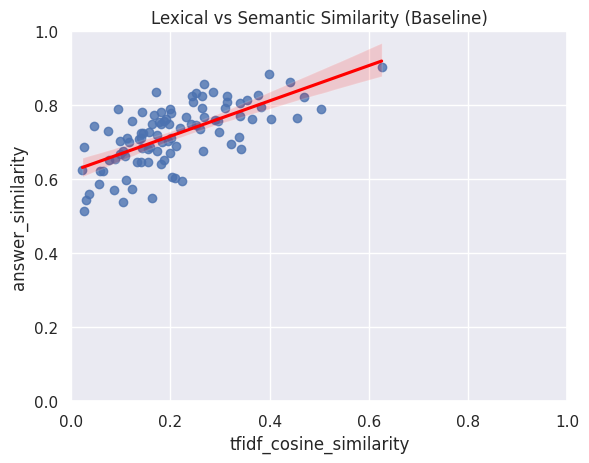

count    96.000000
mean      0.720513
std       0.083755
min       0.514134
25%       0.669470
50%       0.727942
75%       0.778804
max       0.902700
Name: answer_similarity, dtype: float64
count    96.000000
mean      0.208148
std       0.116507
min       0.022543
25%       0.129736
50%       0.187318
75%       0.267456
max       0.625784
Name: tfidf_cosine_similarity, dtype: float64
PearsonRResult(statistic=0.7315660981243265, pvalue=2.929499516721e-06)
SignificanceResult(statistic=0.7346774193548389, pvalue=2.5295107780101792e-06)


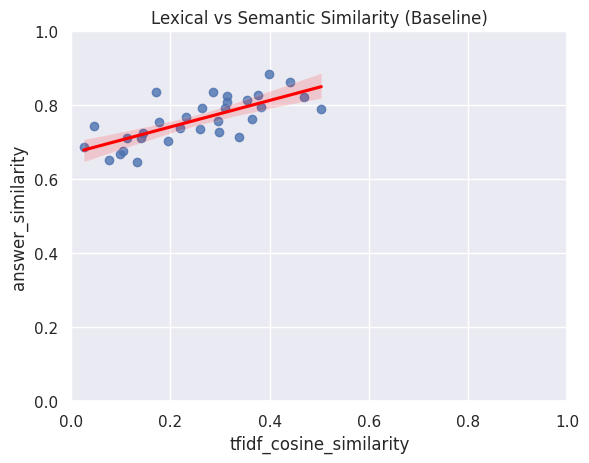

count    31.000000
mean      0.760505
std       0.062766
min       0.647446
25%       0.712994
50%       0.756481
75%       0.811495
max       0.883489
Name: answer_similarity, dtype: float64
count    31.000000
mean      0.252897
std       0.128240
min       0.025049
25%       0.142082
50%       0.263397
75%       0.346730
max       0.504079
Name: tfidf_cosine_similarity, dtype: float64


In [143]:
correlation_plot(full_monty[3], 'Baseline')
print(full_monty[3]['answer_similarity'].describe())
print(full_monty[3]['tfidf_cosine_similarity'].describe())
correlation_plot(QA_stats[3], 'Baseline')
print(QA_stats[3]['answer_similarity'].describe())
print(QA_stats[3]['tfidf_cosine_similarity'].describe())